# 데이터 (merged)

In [1]:
ver = 1
k_list = [10]
umap = 3
epoch = 50

In [6]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import warnings; warnings.filterwarnings("always"); warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import import_ipynb
from my_functions_6 import *

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

data_dir = './data/'

data = pd.read_feather(
    data_dir + 'clustering_data_1901_2004_ver{0}.ftr'.format(ver))
info_features = data.loc[:, :'지역'].columns.tolist()
features = data.loc[:, '가정용품':'주거'].columns.tolist()


In [7]:
all_data_k = {}

for k in k_list:

    df = data.copy()

    # 라벨 붙이기
    pred = pd.read_csv(
        data_dir + 'clustering_results/ver{0}/pred_cluster{1}_umap{2}_epochs{3}_batchsize64.csv'.format(ver, k, umap, epoch))
    df['cluster'] = pred['0'].values

    # 클러스터 관측 수 많은 순으로 정렬
    as_is_list = df.cluster.value_counts().keys()
    to_be_list = range(1, k+1)
    replacing_dict = dict(zip(as_is_list, to_be_list))
    df['cluster'] = df['cluster'].replace(replacing_dict)

    all_data_k[k] = df


In [8]:
# 이용금액 붙이기 위해 다른 데이터 가져 옴
data2 = pd.read_feather(data_dir + 'data_1901_2004_classified_2_outliered.ftr',  # 88656835 rows
                        columns=['년', '월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '이용금액', '이용건수', '업종'])  # index col 빼고 읽어오기


In [9]:
all_data = {}

for k, item in tqdm(all_data_k.items()):

    data = item.copy()

    """ 고객 그룹별 전체 이용금액 """

    grouped = data2.groupby(['년', '월', '가맹점소재지1', '가맹점소재지2', '성별','연령대별', '연평균소득추정']) # ['년', '월', '가맹점소재지1', '가맹점소재지2', '성별','연령대별', '연평균소득추정']
    grouped_sum = grouped['이용금액'].sum()
    df_spend_total = pd.DataFrame(grouped_sum)

    """ reverse dict """ 

    with open(data_dir + 'dict_pickle/region1_dict.pickle', 'rb') as fr:
        region1_dict = pickle.load(fr)
    with open(data_dir + 'dict_pickle/region2_dict.pickle', 'rb') as fr:
        region2_dict = pickle.load(fr)
    with open(data_dir + 'dict_pickle/gender_dict.pickle', 'rb') as fr:
        gender_dict = pickle.load(fr)
    with open(data_dir + 'dict_pickle/age_dict.pickle', 'rb') as fr:
        age_dict = pickle.load(fr)
    with open(data_dir + 'dict_pickle/income_dict.pickle', 'rb') as fr:
        income_dict = pickle.load(fr)

    region1_dict = {value : key for (key, value) in region1_dict.items()}
    region2_dict = {value : key for (key, value) in region2_dict.items()}
    gender_dict = {value : key for (key, value) in gender_dict.items()}
    age_dict = {value : key for (key, value) in age_dict.items()}
    income_dict = {value : key for (key, value) in income_dict.items()}

    df_spend_total.rename(index = region1_dict, level=2, inplace=True)
    df_spend_total.rename(index = region2_dict, level=3, inplace=True)
    df_spend_total.rename(index = gender_dict, level=4, inplace=True)
    df_spend_total.rename(index = age_dict, level=5, inplace=True)
    df_spend_total.rename(index = income_dict, level=6, inplace=True)
    df_spend_total.reset_index(inplace=True)

    merged = data.merge(df_spend_total, on=['년','월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정'], how='left')

    all_data[k] = merged


100%|██████████| 1/1 [00:17<00:00, 17.54s/it]


In [10]:
merged = all_data[10].copy()

In [11]:
merged


,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,지역,가정용품,개인미용,...,여객운송,오락_문화,음식점,의류_잡화,전자상거래,정보통신,종합소매,주거,cluster,이용금액
0,2019,1,경기도,가평군,남성,20대,B1,수도권,0.000000,0.000000,...,0.0,0.043812,0.327448,0.058830,0.0,0.000000,0.495890,0.000000,5,8390330.0
1,2019,1,경기도,가평군,남성,20대,B2,수도권,0.000000,0.013577,...,0.0,0.060357,0.395716,0.042880,0.0,0.000417,0.324901,0.010090,5,143975888.0
2,2019,1,경기도,가평군,남성,20대,B3,수도권,0.000000,0.006469,...,0.0,0.055328,0.393759,0.023631,0.0,0.000163,0.320731,0.011607,5,245555936.0
3,2019,1,경기도,가평군,남성,20대,B4,수도권,0.000000,0.005835,...,0.0,0.054971,0.416707,0.022155,0.0,0.000000,0.354613,0.015210,5,119837440.0
4,2019,1,경기도,가평군,남성,20대,B5,수도권,0.000000,0.000000,...,0.0,0.086319,0.330401,0.012763,0.0,0.000000,0.438105,0.013784,5,8630734.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312540,2020,4,충청북도,충주시,여성,60대 이상,B2,기타,0.005579,0.019747,...,0.0,0.034893,0.114931,0.057092,0.0,0.000164,0.254906,0.007800,1,261343968.0
312541,2020,4,충청북도,충주시,여성,60대 이상,B3,기타,0.029227,0.022472,...,0.0,0.080076,0.120656,0.033512,0.0,0.000408,0.243995,0.014730,1,794481216.0
312542,2020,4,충청북도,충주시,여성,60대 이상,B4,기타,0.016502,0.022778,...,0.0,0.148258,0.136114,0.023608,0.0,0.000167,0.226666,0.010410,2,605262592.0
312543,2020,4,충청북도,충주시,여성,60대 이상,B5,기타,0.000000,0.000000,...,0.0,0.246296,0.184772,0.049689,0.0,0.000000,0.264008,0.001485,3,16506580.0


In [8]:
# 고객 그룹화

def group_age_income(data):

    df = data.copy()

    df['연령대별'] = df['연령대별'].replace(dict.fromkeys(
        ['20세 미만', '20대', '30대'], '1030'))
    df['연령대별'] = df['연령대별'].replace(dict.fromkeys(
        ['40대', '50대'], '4050'))
    df['연령대별'] = df['연령대별'].replace(dict.fromkeys(
        ['60대 이상'], '60+'))

    df['연평균소득추정'] = df['연평균소득추정'].replace(dict.fromkeys(
        ['B1', 'B2', 'B3'], '소득_Low'))
    df['연평균소득추정'] = df['연평균소득추정'].replace(dict.fromkeys(
        ['B4'], '소득_Medium'))
    df['연평균소득추정'] = df['연평균소득추정'].replace(dict.fromkeys(
        ['B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11'], '소득_High'))

    df['지역'] = df['지역'].replace(dict.fromkeys(
        ['부산울산권', '대구권', '광주권', '대전권', '기타'], '비수도권'))
    return df


merged_grouped = group_age_income(merged)

# 1.. transition matrix
- 분석 대상 그룹
    - 성별, 연령, 소득, 지역
- 그룹 비율도 가중치로 반영해야 함
- 그룹 수가 많아서, 중간에 관측 끊기는 경우도 있음 주의

### 고객 전체

In [10]:
matrix = transition_matrix(merged)
color_df(matrix)

100%|██████████| 22793/22793 [10:53<00:00, 34.86it/s]

total number of transitions:  289752


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.706108,0.062090,0.065705,0.014966,0.052850,0.012363,0.006232,0.045186,0.015183,0.019318
2,0.082761,0.711892,0.008089,0.019425,0.060228,0.075110,0.001893,0.005300,0.031239,0.004064
3,0.148795,0.013650,0.683066,0.011677,0.058192,0.008895,0.014394,0.014685,0.028336,0.018308
4,0.036158,0.035622,0.012041,0.884379,0.009361,0.001715,0.004752,0.004859,0.010790,0.000322
5,0.157907,0.134815,0.076107,0.012252,0.474449,0.037439,0.003325,0.018264,0.036345,0.049098
6,0.039894,0.180186,0.011411,0.002963,0.037594,0.650243,0.003848,0.007607,0.047192,0.019062
7,0.019905,0.004670,0.019150,0.006179,0.003490,0.003773,0.921041,0.014386,0.004387,0.003019
8,0.164040,0.014707,0.023542,0.008433,0.021835,0.008684,0.016314,0.699227,0.022136,0.021082
9,0.054737,0.073705,0.046120,0.018264,0.044277,0.055441,0.005203,0.021840,0.657002,0.023412


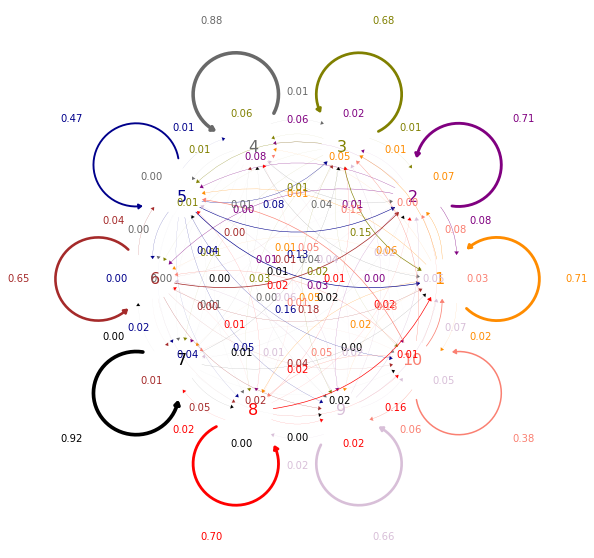

In [11]:
transition_graph(matrix)

## 고객 그룹별

In [12]:
# 성별 연령대별 연평균소득추정 지역

gender_list = merged_grouped['성별'].unique().tolist()
age_list = merged_grouped['연령대별'].unique().tolist()
income_list = merged_grouped['연평균소득추정'].unique().tolist()
region_list = merged_grouped['지역'].unique().tolist()

k=10

for gender in gender_list:
    for age in age_list:
        for income in income_list:
            for region in region_list:
                print('{0}  {1}  {2}  {3}'.format(gender, age, income, region))
                df_filtered = filter_df(merged_grouped, [gender], [age], [income], [region])
                matrix = transition_matrix(df_filtered)
                color_df(matrix)


남성  1030  소득_Low  수도권


100%|██████████| 66/66 [00:07<00:00,  8.73it/s]

total number of transitions:  8699


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.433159,0.112058,0.287680,0.011796,0.062910,0.000000,0.002621,0.069463,0.013106,0.007208
2,0.098093,0.377384,0.392371,0.005450,0.100817,0.001362,0.000000,0.014986,0.005450,0.004087
3,0.141770,0.020615,0.594672,0.001269,0.136378,0.002220,0.020615,0.046939,0.017761,0.017761
4,0.176471,0.058824,0.647059,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.136719,0.187500,0.251953,0.003906,0.351562,0.005859,0.002930,0.008789,0.025391,0.025391
6,0.200000,0.450000,0.000000,0.000000,0.200000,0.000000,0.100000,0.000000,0.050000,0.000000
7,0.000789,0.000000,0.052881,0.000000,0.003157,0.000000,0.915549,0.026046,0.001579,0.000000
8,0.246677,0.051699,0.079764,0.001477,0.035451,0.002954,0.045790,0.530281,0.004431,0.001477
9,0.106918,0.006289,0.477987,0.000000,0.037736,0.012579,0.006289,0.062893,0.283019,0.006289


남성  1030  소득_Low  비수도권


100%|██████████| 163/163 [00:16<00:00,  9.82it/s]

total number of transitions:  18730


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.390098,0.129735,0.225171,0.015508,0.168208,0.012824,0.000298,0.031613,0.005368,0.021175
2,0.100027,0.381725,0.206272,0.011895,0.200054,0.045958,0.003244,0.002163,0.009732,0.038929
3,0.176433,0.062245,0.451599,0.011161,0.206697,0.010303,0.001073,0.043572,0.011376,0.025542
4,0.169492,0.233898,0.115254,0.061017,0.318644,0.077966,0.000000,0.003390,0.010169,0.010169
5,0.094966,0.257639,0.137393,0.014729,0.402726,0.030996,0.001319,0.004616,0.012530,0.043086
6,0.108772,0.219298,0.133333,0.043860,0.205263,0.166667,0.003509,0.000000,0.049123,0.070175
7,0.125000,0.281250,0.093750,0.031250,0.281250,0.000000,0.093750,0.031250,0.031250,0.031250
8,0.302115,0.074018,0.104230,0.012085,0.027190,0.000000,0.000000,0.474320,0.001511,0.004532
9,0.089606,0.093190,0.283154,0.007168,0.143369,0.068100,0.000000,0.010753,0.254480,0.050179


남성  1030  소득_Medium  수도권


100%|██████████| 66/66 [00:02<00:00, 25.08it/s]

total number of transitions:  3062


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.250000,0.108108,0.513514,0.013514,0.033784,0.003378,0.000000,0.057432,0.016892,0.003378
2,0.098418,0.084359,0.451670,0.000000,0.358524,0.000000,0.000000,0.005272,0.001757,0.000000
3,0.095925,0.389643,0.360781,0.052632,0.011885,0.000000,0.033107,0.036503,0.017827,0.001698
4,0.080000,0.066667,0.720000,0.000000,0.120000,0.000000,0.000000,0.013333,0.000000,0.000000
5,0.056667,0.080000,0.656667,0.006667,0.143333,0.010000,0.003333,0.013333,0.010000,0.020000
6,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.091765,0.000000,0.002353,0.000000,0.868235,0.037647,0.000000,0.000000
8,0.112994,0.067797,0.180791,0.011299,0.005650,0.000000,0.090395,0.531073,0.000000,0.000000
9,0.266667,0.500000,0.000000,0.233333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


남성  1030  소득_Medium  비수도권


100%|██████████| 163/163 [00:06<00:00, 26.12it/s]

total number of transitions:  7139


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.242708,0.170833,0.375000,0.037500,0.081250,0.044792,0.004167,0.013542,0.007292,0.022917
2,0.109552,0.200756,0.233675,0.004317,0.351322,0.054506,0.001079,0.002159,0.015111,0.027523
3,0.156580,0.419212,0.269850,0.037202,0.032204,0.049972,0.001666,0.014436,0.011105,0.007773
4,0.227513,0.137566,0.275132,0.015873,0.322751,0.010582,0.000000,0.005291,0.005291,0.000000
5,0.102964,0.219189,0.276131,0.038222,0.178627,0.088144,0.003900,0.007020,0.031201,0.054602
6,0.044487,0.303675,0.092843,0.001934,0.243714,0.212766,0.000000,0.003868,0.021277,0.075435
7,0.071429,0.357143,0.214286,0.214286,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000
8,0.101124,0.028090,0.140449,0.005618,0.028090,0.005618,0.000000,0.679775,0.005618,0.005618
9,0.062500,0.347222,0.020833,0.041667,0.201389,0.090278,0.000000,0.000000,0.208333,0.027778


남성  1030  소득_High  수도권


100%|██████████| 66/66 [00:11<00:00,  5.51it/s]

total number of transitions:  13562


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.367190,0.072837,0.229201,0.011026,0.075844,0.008019,0.031073,0.113933,0.017040,0.073839
2,0.474820,0.148201,0.096403,0.015827,0.112230,0.034532,0.010072,0.054676,0.028777,0.024460
3,0.216758,0.032787,0.533437,0.007026,0.056987,0.004944,0.046318,0.029404,0.034348,0.037991
4,0.455285,0.040650,0.162602,0.105691,0.032520,0.000000,0.016260,0.113821,0.073171,0.000000
5,0.218201,0.113754,0.228542,0.003102,0.253361,0.027921,0.009307,0.050672,0.019648,0.075491
6,0.166667,0.118056,0.187500,0.000000,0.208333,0.145833,0.000000,0.034722,0.041667,0.097222
7,0.029287,0.000849,0.086163,0.000849,0.005093,0.000000,0.847199,0.022496,0.005093,0.002971
8,0.158537,0.032520,0.122629,0.005420,0.035908,0.005420,0.029133,0.553523,0.027100,0.029810
9,0.138743,0.078534,0.261780,0.031414,0.052356,0.034031,0.039267,0.091623,0.225131,0.047120


남성  1030  소득_High  비수도권


100%|██████████| 163/163 [00:16<00:00,  9.63it/s]

total number of transitions:  19040


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.362996,0.064447,0.218523,0.010670,0.107128,0.022621,0.010883,0.073410,0.017926,0.111396
2,0.271491,0.198585,0.069641,0.008705,0.201306,0.109358,0.007073,0.017954,0.040805,0.075082
3,0.255387,0.061210,0.435580,0.011921,0.085740,0.011921,0.006190,0.043787,0.026135,0.062127
4,0.266423,0.142336,0.083942,0.051095,0.149635,0.131387,0.000000,0.043796,0.054745,0.076642
5,0.169336,0.131198,0.141876,0.014493,0.267735,0.061404,0.008391,0.019832,0.033562,0.152174
6,0.109833,0.173640,0.082636,0.012552,0.188285,0.224895,0.011506,0.007322,0.070084,0.119247
7,0.202643,0.057269,0.123348,0.026432,0.096916,0.061674,0.251101,0.132159,0.004405,0.044053
8,0.177163,0.035294,0.169550,0.005536,0.029066,0.005536,0.017301,0.512803,0.011765,0.035986
9,0.123077,0.084024,0.108876,0.017751,0.111243,0.062722,0.015385,0.015385,0.377515,0.084024


남성  4050  소득_Low  수도권


100%|██████████| 66/66 [00:05<00:00, 12.49it/s]

total number of transitions:  6121


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.641804,0.133988,0.025904,0.000000,0.098258,0.016079,0.012952,0.041536,0.005806,0.023671
2,0.273262,0.312439,0.021548,0.003918,0.238002,0.063663,0.000979,0.057786,0.005877,0.022527
3,0.295154,0.066079,0.242291,0.000000,0.105727,0.039648,0.176211,0.039648,0.008811,0.026432
4,0.285714,0.285714,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.142857,0.000000
5,0.286093,0.333775,0.035762,0.002649,0.229139,0.058278,0.000000,0.021192,0.006623,0.026490
6,0.107570,0.362550,0.011952,0.000000,0.131474,0.195219,0.071713,0.043825,0.019920,0.055777
7,0.017442,0.004845,0.040698,0.000000,0.000969,0.016473,0.904070,0.013566,0.000000,0.001938
8,0.330166,0.073634,0.023753,0.000000,0.040380,0.016627,0.019002,0.491686,0.002375,0.002375
9,0.135135,0.135135,0.054054,0.000000,0.081081,0.405405,0.000000,0.135135,0.054054,0.000000


남성  4050  소득_Low  비수도권


100%|██████████| 163/163 [00:12<00:00, 13.22it/s]

total number of transitions:  13986


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.589959,0.199186,0.022524,0.001628,0.073813,0.053731,0.002985,0.035007,0.003528,0.017639
2,0.145762,0.376286,0.017148,0.005145,0.164135,0.212641,0.002450,0.023518,0.013964,0.038951
3,0.326693,0.219124,0.063745,0.007968,0.091633,0.203187,0.023904,0.003984,0.043825,0.015936
4,0.102041,0.224490,0.010204,0.010204,0.244898,0.316327,0.000000,0.000000,0.010204,0.081633
5,0.160434,0.439024,0.011382,0.011924,0.180488,0.147425,0.001626,0.004878,0.005962,0.036856
6,0.069571,0.263528,0.013352,0.011595,0.124736,0.435348,0.003162,0.011595,0.018271,0.048840
7,0.463415,0.195122,0.073171,0.024390,0.121951,0.073171,0.024390,0.000000,0.000000,0.024390
8,0.370600,0.115942,0.002070,0.002070,0.041408,0.064182,0.000000,0.403727,0.000000,0.000000
9,0.107955,0.198864,0.056818,0.000000,0.085227,0.426136,0.000000,0.000000,0.102273,0.022727


남성  4050  소득_Medium  수도권


100%|██████████| 66/66 [00:01<00:00, 38.00it/s]

total number of transitions:  2046


next_state,1,2,3,4,5,6,7,8,9
state,,,,,,,,,
1,0.387833,0.475285,0.003802,0.072243,0.026616,0.003802,0.000000,0.022814,0.007605
2,0.107081,0.813472,0.006045,0.024180,0.017271,0.030225,0.000000,0.000864,0.000864
3,0.000000,0.204545,0.704545,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000
4,0.403509,0.491228,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.134615,0.442308,0.076923,0.000000,0.326923,0.019231,0.000000,0.000000,0.000000
6,0.018182,0.636364,0.000000,0.000000,0.018182,0.327273,0.000000,0.000000,0.000000
7,0.000000,0.002950,0.002950,0.000000,0.000000,0.000000,0.988201,0.005900,0.000000
8,0.053333,0.040000,0.000000,0.000000,0.000000,0.000000,0.026667,0.880000,0.000000
9,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000


남성  4050  소득_Medium  비수도권


100%|██████████| 163/163 [00:04<00:00, 37.39it/s]

total number of transitions:  5053


next_state,1,2,3,4,5,6,7,8,9
state,,,,,,,,,
1,0.724800,0.209600,0.003200,0.006400,0.009600,0.040000,0.006400,0.000000,0.000000
2,0.042291,0.791542,0.004995,0.002664,0.029637,0.121545,0.000333,0.000333,0.006660
3,0.068966,0.551724,0.034483,0.000000,0.344828,0.000000,0.000000,0.000000,0.000000
4,0.069767,0.232558,0.000000,0.627907,0.000000,0.023256,0.000000,0.046512,0.000000
5,0.050761,0.477157,0.050761,0.000000,0.304569,0.116751,0.000000,0.000000,0.000000
6,0.021678,0.360038,0.000000,0.000943,0.022620,0.578699,0.000000,0.000000,0.016023
7,0.500000,0.100000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000
8,0.000000,0.031250,0.000000,0.062500,0.000000,0.000000,0.000000,0.906250,0.000000
9,0.000000,0.339623,0.000000,0.000000,0.000000,0.452830,0.000000,0.000000,0.207547


남성  4050  소득_High  수도권


100%|██████████| 66/66 [00:12<00:00,  5.16it/s]

total number of transitions:  14659


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.540385,0.194884,0.026732,0.090256,0.039667,0.013510,0.029606,0.044840,0.015522,0.004599
2,0.229762,0.511607,0.010714,0.061012,0.047321,0.028571,0.015476,0.015476,0.079464,0.000595
3,0.164356,0.156436,0.326733,0.073267,0.049505,0.009901,0.156436,0.009901,0.039604,0.013861
4,0.280688,0.110242,0.027365,0.444097,0.023456,0.002346,0.062549,0.024238,0.025020,0.000000
5,0.290526,0.265263,0.096842,0.042105,0.124211,0.037895,0.006316,0.021053,0.094737,0.021053
6,0.097264,0.389058,0.009119,0.012158,0.060790,0.291793,0.021277,0.009119,0.109422,0.000000
7,0.027949,0.024049,0.027949,0.018850,0.002925,0.003575,0.873253,0.018200,0.003250,0.000000
8,0.098205,0.119324,0.010560,0.039071,0.008448,0.004224,0.060190,0.633580,0.026399,0.000000
9,0.018309,0.266783,0.022668,0.025283,0.013949,0.038361,0.007847,0.025283,0.579773,0.001744


남성  4050  소득_High  비수도권


100%|██████████| 163/163 [00:30<00:00,  5.32it/s]

total number of transitions:  33720


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.527324,0.149783,0.042986,0.025991,0.042486,0.065978,0.031656,0.046818,0.052149,0.014828
2,0.120373,0.443423,0.032829,0.019325,0.086496,0.107101,0.012456,0.013970,0.154831,0.009197
3,0.173978,0.198513,0.187361,0.005948,0.063197,0.102602,0.040892,0.031227,0.162825,0.033457
4,0.275651,0.180704,0.035222,0.341501,0.026034,0.010720,0.070444,0.024502,0.035222,0.000000
5,0.163245,0.206309,0.081122,0.011017,0.170255,0.127692,0.010516,0.021032,0.161242,0.047571
6,0.063934,0.248590,0.023129,0.002633,0.043437,0.460323,0.004513,0.010906,0.121662,0.020873
7,0.237852,0.208440,0.026854,0.031969,0.035806,0.043478,0.309463,0.038363,0.062660,0.005115
8,0.188982,0.127008,0.026014,0.010712,0.016067,0.063504,0.022953,0.485080,0.052028,0.007651
9,0.034810,0.171077,0.024197,0.002689,0.032687,0.122541,0.009339,0.008773,0.574077,0.019810


남성  60+  소득_Low  수도권


100%|██████████| 66/66 [00:02<00:00, 25.12it/s]

total number of transitions:  3101


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.843019,0.104876,0.010688,0.000668,0.006680,0.020040,0.006012,0.008016,0.000000,0.000000
2,0.285714,0.481203,0.003759,0.000000,0.024436,0.187970,0.000000,0.013158,0.001880,0.001880
3,0.384615,0.051282,0.282051,0.000000,0.025641,0.205128,0.000000,0.000000,0.051282,0.000000
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.371429,0.285714,0.057143,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000
6,0.062670,0.297003,0.019074,0.000000,0.021798,0.577657,0.019074,0.000000,0.002725,0.000000
7,0.015625,0.003906,0.000000,0.000000,0.000000,0.013672,0.964844,0.001953,0.000000,0.000000
8,0.106195,0.026549,0.008850,0.000000,0.017699,0.008850,0.017699,0.814159,0.000000,0.000000
9,0.250000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


남성  60+  소득_Low  비수도권


100%|██████████| 163/163 [00:06<00:00, 23.87it/s]

total number of transitions:  7598


next_state,1,2,3,5,6,7,8,9
state,,,,,,,,
1,0.814302,0.139690,0.000000,0.001109,0.027162,0.001109,0.009424,0.007206
2,0.178862,0.477458,0.001478,0.008130,0.327421,0.000739,0.005174,0.000739
3,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
5,0.032258,0.451613,0.000000,0.032258,0.483871,0.000000,0.000000,0.000000
6,0.010979,0.106517,0.000467,0.003504,0.877365,0.000000,0.000000,0.001168
7,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.218391,0.068966,0.000000,0.000000,0.000000,0.000000,0.712644,0.000000
9,0.400000,0.000000,0.000000,0.000000,0.228571,0.000000,0.000000,0.371429


남성  60+  소득_Medium  수도권


100%|██████████| 66/66 [00:00<00:00, 77.93it/s]

total number of transitions:  990


next_state,1,2,3,5,6,7,8,9
state,,,,,,,,
1,0.949721,0.044693,0.000000,0.000000,0.000000,0.005587,0.000000,0.000000
2,0.051780,0.847896,0.000000,0.012945,0.067961,0.003236,0.006472,0.009709
3,0.000000,0.000000,0.933333,0.000000,0.000000,0.066667,0.000000,0.000000
5,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.184466,0.000000,0.000000,0.815534,0.000000,0.000000,0.000000
7,0.012903,0.006452,0.000000,0.000000,0.000000,0.974194,0.006452,0.000000
8,0.000000,0.057143,0.000000,0.000000,0.000000,0.028571,0.914286,0.000000
9,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.777778


남성  60+  소득_Medium  비수도권


100%|██████████| 163/163 [00:02<00:00, 77.96it/s]

total number of transitions:  2445


next_state,1,2,5,6,7,8,9
state,,,,,,,
1,0.888393,0.098214,0.000000,0.008929,0.004464,0.000000,0.000000
2,0.042296,0.778449,0.005035,0.169184,0.000000,0.000000,0.005035
5,0.000000,0.285714,0.714286,0.000000,0.000000,0.000000,0.000000
6,0.004215,0.172813,0.000000,0.819810,0.000000,0.000000,0.003161
7,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.222222,0.000000,0.388889,0.000000,0.000000,0.388889


남성  60+  소득_High  수도권


100%|██████████| 66/66 [00:06<00:00, 10.79it/s]

total number of transitions:  7147


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.680341,0.099513,0.021527,0.002843,0.038587,0.015841,0.025183,0.074736,0.034525,0.006905
2,0.311688,0.341658,0.025974,0.000000,0.073926,0.052947,0.029970,0.021978,0.139860,0.001998
3,0.274112,0.147208,0.248731,0.005076,0.065990,0.020305,0.131980,0.050761,0.050761,0.005076
4,0.200000,0.100000,0.100000,0.000000,0.000000,0.000000,0.400000,0.100000,0.100000,0.000000
5,0.311284,0.190661,0.038911,0.003891,0.081712,0.081712,0.007782,0.054475,0.186770,0.042802
6,0.177215,0.295359,0.025316,0.000000,0.071730,0.236287,0.008439,0.037975,0.118143,0.029536
7,0.054519,0.020803,0.020086,0.000717,0.000000,0.003587,0.878766,0.011478,0.009326,0.000717
8,0.222576,0.076312,0.019078,0.000000,0.019078,0.014308,0.036566,0.542130,0.068362,0.001590
9,0.059603,0.207506,0.012141,0.000000,0.022075,0.046358,0.025386,0.023179,0.601545,0.002208


남성  60+  소득_High  비수도권


100%|██████████| 163/163 [00:12<00:00, 13.00it/s]

total number of transitions:  14117


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.572482,0.101966,0.028256,0.000921,0.031327,0.055283,0.012592,0.086302,0.093980,0.016892
2,0.174045,0.311767,0.029512,0.000000,0.089671,0.124101,0.004540,0.020053,0.230420,0.015891
3,0.196721,0.142857,0.103044,0.000000,0.072600,0.105386,0.021077,0.025761,0.295082,0.037471
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.176627,0.180611,0.071713,0.000000,0.154050,0.138114,0.006640,0.037185,0.188579,0.046481
6,0.095818,0.238221,0.027528,0.000000,0.055056,0.385389,0.009529,0.016940,0.138698,0.032822
7,0.308458,0.119403,0.034826,0.000000,0.024876,0.104478,0.203980,0.039801,0.154229,0.009950
8,0.230678,0.101070,0.011891,0.000000,0.020214,0.048751,0.045184,0.455410,0.080856,0.005945
9,0.061604,0.163303,0.023367,0.000000,0.035582,0.090016,0.010621,0.010356,0.582847,0.022305


여성  1030  소득_Low  수도권


100%|██████████| 66/66 [00:07<00:00,  8.59it/s]

total number of transitions:  8818


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.231707,0.003484,0.238676,0.380662,0.022648,0.001742,0.006098,0.081882,0.014808,0.018293
2,0.200000,0.054545,0.472727,0.200000,0.000000,0.000000,0.000000,0.036364,0.018182,0.018182
3,0.176257,0.007268,0.378558,0.225318,0.027256,0.001211,0.047244,0.101151,0.015748,0.019988
4,0.124960,0.010894,0.152515,0.633130,0.020186,0.000000,0.008331,0.022108,0.013778,0.014098
5,0.146341,0.004878,0.180488,0.307317,0.234146,0.004878,0.000000,0.029268,0.043902,0.048780
6,0.000000,0.000000,0.000000,0.571429,0.000000,0.000000,0.285714,0.000000,0.142857,0.000000
7,0.012402,0.000000,0.049608,0.011749,0.001305,0.001305,0.896214,0.024804,0.002611,0.000000
8,0.086101,0.001230,0.072571,0.238622,0.009840,0.000000,0.041820,0.526445,0.009840,0.013530
9,0.093168,0.000000,0.211180,0.273292,0.018634,0.000000,0.099379,0.018634,0.285714,0.000000


여성  1030  소득_Low  비수도권


100%|██████████| 163/163 [00:17<00:00,  9.55it/s]

total number of transitions:  19333


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.268652,0.013480,0.126959,0.389342,0.071787,0.008464,0.000940,0.040125,0.046708,0.033542
2,0.187316,0.103245,0.064897,0.143068,0.234513,0.058997,0.001475,0.017699,0.054572,0.134218
3,0.211547,0.018014,0.328868,0.266975,0.048499,0.008314,0.009238,0.045727,0.038799,0.024018
4,0.130759,0.041136,0.073387,0.632734,0.055836,0.010421,0.001645,0.017552,0.015138,0.021391
5,0.115210,0.065372,0.073786,0.320388,0.214239,0.033657,0.000647,0.016828,0.088026,0.071845
6,0.092105,0.049342,0.046053,0.282895,0.157895,0.125000,0.000000,0.000000,0.092105,0.154605
7,0.084746,0.016949,0.135593,0.169492,0.000000,0.000000,0.016949,0.508475,0.050847,0.016949
8,0.170077,0.005115,0.097187,0.274936,0.010230,0.000000,0.017903,0.401535,0.011509,0.011509
9,0.042341,0.013699,0.031133,0.635118,0.057285,0.017435,0.001245,0.003736,0.174346,0.023661


여성  1030  소득_Medium  수도권


100%|██████████| 66/66 [00:02<00:00, 25.56it/s]

total number of transitions:  3060


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.137645,0.000000,0.514096,0.258706,0.018242,0.000000,0.004975,0.031509,0.021559,0.013267
2,0.000000,0.111111,0.222222,0.111111,0.555556,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.024675,0.000000,0.189610,0.676623,0.005195,0.000000,0.076623,0.016883,0.007792,0.002597
4,0.497048,0.004723,0.244392,0.116883,0.041322,0.002361,0.003542,0.066116,0.007084,0.016529
5,0.092105,0.052632,0.118421,0.552632,0.118421,0.000000,0.000000,0.026316,0.013158,0.026316
6,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.017928,0.000000,0.105578,0.019920,0.000000,0.000000,0.828685,0.023904,0.003984,0.000000
8,0.170984,0.000000,0.155440,0.093264,0.056995,0.000000,0.062176,0.450777,0.005181,0.005181
9,0.033333,0.000000,0.000000,0.600000,0.000000,0.000000,0.366667,0.000000,0.000000,0.000000


여성  1030  소득_Medium  비수도권


100%|██████████| 163/163 [00:05<00:00, 29.14it/s]

total number of transitions:  6553


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.195876,0.004124,0.271478,0.437801,0.026804,0.000687,0.002749,0.007560,0.010309,0.042612
2,0.165138,0.027523,0.100917,0.311927,0.155963,0.018349,0.000000,0.018349,0.110092,0.091743
3,0.086349,0.005757,0.204770,0.638980,0.015625,0.000822,0.015625,0.011513,0.010691,0.009868
4,0.362656,0.025442,0.179388,0.116861,0.125485,0.031479,0.002587,0.052609,0.022423,0.081069
5,0.135965,0.017544,0.087719,0.526316,0.072368,0.006579,0.002193,0.004386,0.037281,0.109649
6,0.072727,0.027273,0.027273,0.527273,0.063636,0.100000,0.009091,0.009091,0.063636,0.100000
7,0.066667,0.000000,0.377778,0.155556,0.000000,0.000000,0.022222,0.333333,0.000000,0.044444
8,0.193676,0.007905,0.197628,0.193676,0.019763,0.003953,0.047431,0.296443,0.003953,0.035573
9,0.081633,0.066327,0.056122,0.265306,0.096939,0.035714,0.000000,0.015306,0.285714,0.096939


여성  1030  소득_High  수도권


100%|██████████| 66/66 [00:08<00:00,  7.94it/s]

total number of transitions:  9689


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.361264,0.006021,0.195183,0.116407,0.047165,0.003512,0.044155,0.131962,0.021074,0.073256
2,0.130435,0.065217,0.130435,0.086957,0.152174,0.021739,0.043478,0.086957,0.108696,0.173913
3,0.207792,0.002498,0.460040,0.078422,0.054446,0.002498,0.079920,0.041958,0.030969,0.041459
4,0.372907,0.013699,0.079148,0.035008,0.036530,0.021309,0.019787,0.315068,0.036530,0.070015
5,0.221024,0.021563,0.218329,0.137466,0.167116,0.013477,0.056604,0.072776,0.024259,0.067385
6,0.461538,0.051282,0.025641,0.076923,0.128205,0.076923,0.000000,0.051282,0.025641,0.102564
7,0.036348,0.001268,0.071851,0.003381,0.004649,0.000423,0.845731,0.027895,0.002959,0.005495
8,0.173565,0.000668,0.104139,0.075434,0.018024,0.000668,0.042724,0.534045,0.025367,0.025367
9,0.111111,0.006536,0.235294,0.084967,0.029412,0.006536,0.042484,0.107843,0.349673,0.026144


여성  1030  소득_High  비수도권


100%|██████████| 162/162 [00:08<00:00, 18.40it/s]

total number of transitions:  10258


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.395774,0.013560,0.157048,0.097130,0.072848,0.009776,0.011038,0.104699,0.020183,0.117944
2,0.209877,0.168724,0.078189,0.065844,0.185185,0.065844,0.016461,0.037037,0.032922,0.139918
3,0.281872,0.012910,0.360947,0.092523,0.048413,0.007531,0.014524,0.075847,0.030124,0.075309
4,0.416157,0.020808,0.123623,0.040392,0.074663,0.004896,0.004896,0.223990,0.017136,0.073439
5,0.277279,0.059050,0.121951,0.066752,0.207959,0.032092,0.021823,0.034660,0.048780,0.129653
6,0.211538,0.065385,0.069231,0.015385,0.119231,0.342308,0.003846,0.019231,0.046154,0.107692
7,0.179487,0.038462,0.089744,0.044872,0.057692,0.044872,0.108974,0.358974,0.025641,0.051282
8,0.206551,0.004679,0.121658,0.093583,0.016043,0.003342,0.029412,0.461898,0.006684,0.056150
9,0.176606,0.027523,0.105505,0.036697,0.077982,0.034404,0.002294,0.032110,0.383028,0.123853


여성  4050  소득_Low  수도권


100%|██████████| 66/66 [00:05<00:00, 12.71it/s]

total number of transitions:  6056


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.607273,0.037727,0.017727,0.151364,0.033636,0.002727,0.018182,0.118636,0.003636,0.009091
2,0.221088,0.268707,0.020408,0.221088,0.085034,0.020408,0.000000,0.085034,0.017007,0.061224
3,0.275862,0.034483,0.268966,0.179310,0.041379,0.000000,0.089655,0.089655,0.013793,0.006897
4,0.301131,0.046127,0.013055,0.457789,0.054830,0.006092,0.004352,0.101828,0.000870,0.013925
5,0.320675,0.215190,0.016878,0.219409,0.164557,0.000000,0.000000,0.012658,0.000000,0.050633
6,0.057143,0.114286,0.028571,0.342857,0.057143,0.028571,0.371429,0.000000,0.000000,0.000000
7,0.029973,0.000000,0.023615,0.000000,0.000908,0.011807,0.925522,0.008174,0.000000,0.000000
8,0.389578,0.022333,0.012407,0.101737,0.007444,0.000000,0.009926,0.455335,0.000000,0.001241
9,0.111111,0.055556,0.055556,0.666667,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000


여성  4050  소득_Low  비수도권


100%|██████████| 163/163 [00:11<00:00, 13.80it/s]

total number of transitions:  13471


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.556825,0.119777,0.013092,0.145961,0.024234,0.006407,0.002228,0.115042,0.004178,0.012256
2,0.097976,0.431738,0.011886,0.255059,0.108577,0.033087,0.003534,0.013813,0.011886,0.032445
3,0.301075,0.274194,0.053763,0.268817,0.069892,0.016129,0.000000,0.000000,0.005376,0.010753
4,0.195097,0.146322,0.015649,0.440532,0.090506,0.021648,0.002347,0.058425,0.009911,0.019562
5,0.114953,0.425234,0.014019,0.208411,0.180374,0.030841,0.001869,0.002804,0.010280,0.011215
6,0.060317,0.561905,0.000000,0.095238,0.104762,0.146032,0.003175,0.003175,0.019048,0.006349
7,0.093750,0.312500,0.062500,0.437500,0.000000,0.062500,0.000000,0.000000,0.031250,0.000000
8,0.360502,0.053292,0.002090,0.319749,0.005225,0.002090,0.001045,0.253918,0.001045,0.001045
9,0.171875,0.273438,0.031250,0.250000,0.078125,0.085938,0.000000,0.000000,0.101562,0.007812


여성  4050  소득_Medium  수도권


100%|██████████| 66/66 [00:01<00:00, 37.59it/s]

total number of transitions:  2046


next_state,1,2,3,4,5,7,8
state,,,,,,,
1,0.003333,0.006667,0.000000,0.925000,0.000000,0.031667,0.033333
2,0.025641,0.301282,0.000000,0.589744,0.032051,0.000000,0.051282
3,0.000000,0.000000,0.000000,0.294118,0.176471,0.529412,0.000000
4,0.815068,0.132877,0.005479,0.008219,0.006849,0.016438,0.015068
5,0.000000,0.277778,0.166667,0.222222,0.333333,0.000000,0.000000
7,0.048101,0.000000,0.027848,0.032911,0.000000,0.883544,0.007595
8,0.138462,0.084615,0.000000,0.092308,0.000000,0.023077,0.661538


여성  4050  소득_Medium  비수도권


100%|██████████| 163/163 [00:04<00:00, 37.21it/s]

total number of transitions:  5053


next_state,1,2,3,4,5,6,7,8,9
state,,,,,,,,,
1,0.194265,0.062905,0.000000,0.727105,0.000000,0.000925,0.004625,0.010176,0.000000
2,0.037500,0.462500,0.000568,0.407386,0.009659,0.047727,0.000000,0.016477,0.018182
3,0.000000,0.111111,0.111111,0.111111,0.666667,0.000000,0.000000,0.000000,0.000000
4,0.506039,0.471618,0.000604,0.007246,0.003623,0.010266,0.000000,0.000000,0.000604
5,0.018868,0.283019,0.113208,0.132075,0.301887,0.150943,0.000000,0.000000,0.000000
6,0.003448,0.275862,0.000000,0.082759,0.031034,0.524138,0.000000,0.000000,0.082759
7,0.160000,0.000000,0.000000,0.040000,0.000000,0.000000,0.800000,0.000000,0.000000
8,0.186667,0.373333,0.000000,0.013333,0.000000,0.000000,0.000000,0.426667,0.000000
9,0.000000,0.346154,0.000000,0.000000,0.009615,0.250000,0.000000,0.000000,0.394231


여성  4050  소득_High  수도권


100%|██████████| 66/66 [00:06<00:00,  9.56it/s]

total number of transitions:  7954


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.431064,0.068655,0.018008,0.110861,0.034328,0.018571,0.047833,0.216095,0.020822,0.033765
2,0.189931,0.141876,0.043478,0.080092,0.091533,0.045767,0.036613,0.146453,0.189931,0.034325
3,0.211268,0.154930,0.176056,0.091549,0.035211,0.007042,0.147887,0.091549,0.035211,0.049296
4,0.361793,0.058698,0.017076,0.278549,0.036286,0.009605,0.040555,0.149413,0.037353,0.010672
5,0.266055,0.105505,0.050459,0.133028,0.050459,0.022936,0.041284,0.146789,0.087156,0.096330
6,0.206186,0.206186,0.000000,0.247423,0.051546,0.041237,0.000000,0.123711,0.072165,0.051546
7,0.022887,0.003521,0.009243,0.010563,0.007042,0.000440,0.893046,0.044454,0.003961,0.004842
8,0.205919,0.034635,0.005038,0.161839,0.012594,0.006297,0.042821,0.497481,0.018262,0.015113
9,0.174757,0.126214,0.016181,0.077670,0.042071,0.045307,0.006472,0.152104,0.300971,0.058252


여성  4050  소득_High  비수도권


100%|██████████| 163/163 [00:10<00:00, 15.91it/s]

total number of transitions:  11310


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.439286,0.149603,0.026984,0.126984,0.050000,0.027778,0.026984,0.106349,0.027381,0.018651
2,0.136083,0.258288,0.046261,0.062452,0.104086,0.087895,0.007325,0.046646,0.212028,0.038936
3,0.149457,0.312500,0.095109,0.078804,0.073370,0.043478,0.019022,0.078804,0.111413,0.038043
4,0.372250,0.124365,0.033841,0.175973,0.074450,0.028765,0.026227,0.084602,0.035533,0.043993
5,0.156291,0.356291,0.039735,0.112583,0.103311,0.064901,0.007947,0.030464,0.101987,0.026490
6,0.084195,0.369276,0.022157,0.045790,0.067947,0.236337,0.004431,0.020679,0.131462,0.017725
7,0.128125,0.090625,0.059375,0.093750,0.006250,0.012500,0.328125,0.196875,0.078125,0.006250
8,0.256153,0.134913,0.009116,0.090246,0.019143,0.010027,0.047402,0.416591,0.006381,0.010027
9,0.031851,0.297279,0.019244,0.077638,0.054413,0.055076,0.012608,0.011944,0.418049,0.021898


여성  60+  소득_Low  수도권


100%|██████████| 66/66 [00:02<00:00, 23.76it/s]

total number of transitions:  3101


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.915295,0.063408,0.006292,0.001452,0.001936,0.000000,0.002420,0.008712,0.000484,0.000000
2,0.383481,0.522124,0.000000,0.000000,0.079646,0.011799,0.000000,0.000000,0.000000,0.002950
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.166667,0.638889,0.000000,0.000000,0.055556,0.083333,0.000000,0.000000,0.027778,0.027778
6,0.000000,0.545455,0.000000,0.000000,0.090909,0.272727,0.090909,0.000000,0.000000,0.000000
7,0.009560,0.000000,0.000000,0.000000,0.000000,0.001912,0.965583,0.022945,0.000000,0.000000
8,0.190476,0.000000,0.000000,0.000000,0.000000,0.000000,0.114286,0.695238,0.000000,0.000000
9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


여성  60+  소득_Low  비수도권


100%|██████████| 163/163 [00:06<00:00, 23.91it/s]

total number of transitions:  7656


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.840239,0.123666,0.000314,0.000314,0.005022,0.018832,0.001255,0.009416,0.000942,0.000000
2,0.135038,0.630285,0.000000,0.000328,0.022616,0.206162,0.000000,0.000000,0.005572,0.000000
3,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
4,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.190083,0.504132,0.000000,0.008264,0.173554,0.115702,0.000000,0.000000,0.008264,0.000000
6,0.040210,0.606643,0.000874,0.000000,0.009615,0.326923,0.000000,0.000874,0.013986,0.000874
7,0.571429,0.285714,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
8,0.312500,0.010417,0.000000,0.000000,0.010417,0.010417,0.000000,0.656250,0.000000,0.000000
9,0.022222,0.311111,0.000000,0.000000,0.088889,0.355556,0.066667,0.000000,0.155556,0.000000


여성  60+  소득_Medium  수도권


100%|██████████| 66/66 [00:00<00:00, 78.92it/s]

total number of transitions:  990


next_state,1,2,4,5,7,8,9
state,,,,,,,
1,0.939490,0.046178,0.000000,0.001592,0.007962,0.001592,0.003185
2,0.171053,0.782895,0.013158,0.032895,0.000000,0.000000,0.000000
4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.142857,0.714286,0.000000,0.142857,0.000000,0.000000,0.000000
7,0.037975,0.000000,0.000000,0.000000,0.943038,0.018987,0.000000
8,0.058824,0.000000,0.000000,0.000000,0.088235,0.823529,0.029412
9,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.777778


여성  60+  소득_Medium  비수도권


100%|██████████| 163/163 [00:02<00:00, 78.06it/s]

total number of transitions:  2445


next_state,1,2,3,4,5,6,7,8,9
state,,,,,,,,,
1,0.842995,0.147343,0.000000,0.000000,0.002415,0.000000,0.006039,0.001208,0.000000
2,0.089914,0.849101,0.000000,0.000000,0.015637,0.035966,0.000000,0.000000,0.009382
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
5,0.023256,0.534884,0.023256,0.000000,0.418605,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.368794,0.000000,0.007092,0.028369,0.539007,0.000000,0.000000,0.056738
7,0.105263,0.000000,0.000000,0.026316,0.000000,0.000000,0.868421,0.000000,0.000000
8,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965517,0.000000
9,0.000000,0.142857,0.000000,0.000000,0.000000,0.119048,0.000000,0.000000,0.738095


여성  60+  소득_High  수도권


100%|██████████| 66/66 [00:03<00:00, 18.07it/s]

total number of transitions:  4277


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.543583,0.035690,0.018531,0.000000,0.074125,0.006863,0.045299,0.232670,0.026767,0.016472
2,0.432990,0.118557,0.046392,0.000000,0.103093,0.041237,0.030928,0.144330,0.061856,0.020619
3,0.306818,0.056818,0.136364,0.000000,0.034091,0.011364,0.147727,0.147727,0.102273,0.056818
4,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
5,0.493506,0.043290,0.051948,0.000000,0.125541,0.017316,0.047619,0.134199,0.051948,0.034632
6,0.205882,0.205882,0.029412,0.000000,0.088235,0.058824,0.000000,0.088235,0.205882,0.117647
7,0.063177,0.006318,0.007220,0.000903,0.014440,0.000000,0.878159,0.028881,0.000903,0.000000
8,0.308511,0.046809,0.012766,0.003191,0.043617,0.003191,0.038298,0.498936,0.030851,0.013830
9,0.198675,0.139073,0.033113,0.000000,0.072848,0.026490,0.019868,0.192053,0.258278,0.059603


여성  60+  소득_High  비수도권


100%|██████████| 163/163 [00:04<00:00, 36.66it/s]

total number of transitions:  5139


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.561550,0.071113,0.020108,0.000000,0.081903,0.023541,0.008337,0.180481,0.033350,0.019617
2,0.269492,0.198305,0.038983,0.000000,0.235593,0.059322,0.010169,0.052542,0.074576,0.061017
3,0.284810,0.101266,0.088608,0.000000,0.151899,0.063291,0.018987,0.075949,0.164557,0.050633
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.313725,0.183007,0.045752,0.000000,0.253268,0.035948,0.001634,0.040850,0.076797,0.049020
6,0.231132,0.245283,0.037736,0.000000,0.089623,0.216981,0.004717,0.023585,0.089623,0.061321
7,0.545455,0.045455,0.060606,0.000000,0.030303,0.015152,0.015152,0.196970,0.060606,0.030303
8,0.364848,0.049697,0.030303,0.001212,0.043636,0.009697,0.026667,0.436364,0.029091,0.008485
9,0.110870,0.091304,0.047826,0.000000,0.123913,0.050000,0.023913,0.043478,0.434783,0.073913


### 1030

In [8]:
gender = ['남성']
age = ['1030']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_M_1030 = transition_matrix(df_filtered)
color_df(matrix_M_1030)

100%|██████████| 687/687 [00:44<00:00, 15.37it/s]

total number of transitions:  52775


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.415029,0.148243,0.128074,0.024338,0.053357,0.087056,0.024934,0.054634,0.041103,0.023232
2,0.153118,0.490498,0.130850,0.040017,0.047384,0.026622,0.066304,0.022855,0.012892,0.009460
3,0.162744,0.161640,0.411999,0.034140,0.086289,0.024528,0.034250,0.041542,0.019998,0.022870
4,0.065371,0.085205,0.081360,0.670310,0.028334,0.013965,0.030561,0.011536,0.008500,0.004857
5,0.163329,0.210725,0.117935,0.036938,0.355140,0.023810,0.037606,0.027815,0.012906,0.013796
6,0.316025,0.086243,0.082065,0.021785,0.054611,0.294241,0.022680,0.060877,0.045360,0.016115
7,0.123624,0.242480,0.132795,0.060895,0.052091,0.031181,0.306676,0.021277,0.018342,0.010638
8,0.266221,0.132156,0.159351,0.035305,0.096374,0.114504,0.023378,0.114981,0.030057,0.027672
9,0.213298,0.108624,0.127716,0.026991,0.090191,0.148782,0.025016,0.036866,0.203423,0.019092


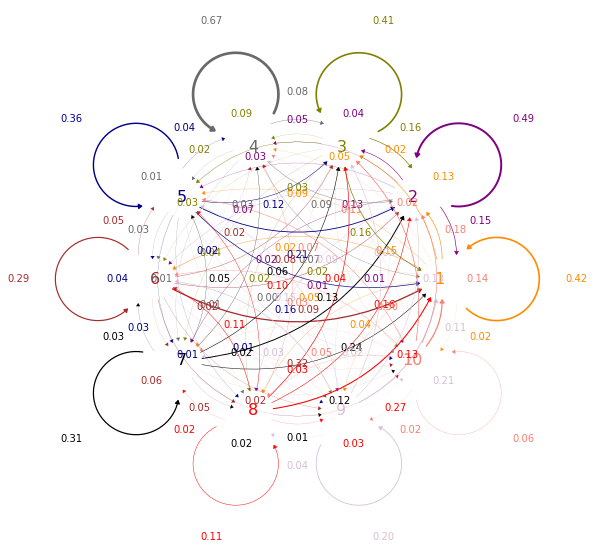

In [9]:
transition_graph(matrix_M_1030)

In [10]:
gender = ['여성']
age = ['1030']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_F_1030 = transition_matrix(df_filtered)
color_df(matrix_F_1030)

100%|██████████| 686/686 [00:35<00:00, 19.31it/s]

total number of transitions:  42718


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.407892,0.153790,0.126272,0.027310,0.057529,0.089304,0.023157,0.053479,0.041952,0.019315
2,0.156105,0.471905,0.138889,0.047740,0.050803,0.025877,0.066962,0.021652,0.012357,0.007710
3,0.163749,0.162233,0.393246,0.039145,0.097312,0.026327,0.034873,0.043280,0.017781,0.022054
4,0.073237,0.095084,0.081182,0.635799,0.031033,0.019364,0.034508,0.014896,0.009682,0.005214
5,0.167583,0.196910,0.123069,0.036397,0.352972,0.032207,0.035873,0.029851,0.014140,0.010998
6,0.295597,0.087352,0.081761,0.020615,0.058351,0.312369,0.026205,0.057652,0.047170,0.012928
7,0.121311,0.260890,0.142389,0.063232,0.062295,0.035597,0.262295,0.028103,0.015457,0.008431
8,0.297170,0.126769,0.159788,0.040684,0.086675,0.106722,0.030660,0.099646,0.023585,0.028302
9,0.230640,0.111111,0.135522,0.036195,0.081650,0.137205,0.038721,0.032828,0.186869,0.009259


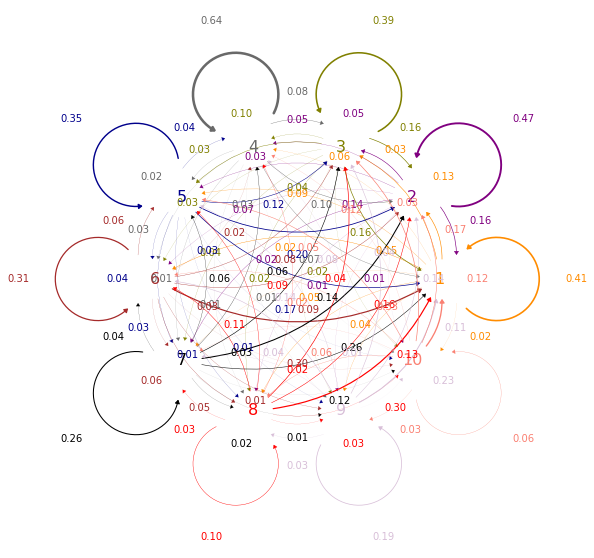

In [11]:
transition_graph(matrix_F_1030)

In [12]:
gender = None
age = ['1030']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_1030 = transition_matrix(df_filtered)
color_df(matrix_1030)

100%|██████████| 1373/1373 [01:30<00:00, 15.20it/s]

total number of transitions:  95493


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.411814,0.150741,0.127263,0.025677,0.055236,0.088069,0.024134,0.054113,0.041485,0.021468
2,0.154439,0.482277,0.134404,0.043432,0.048896,0.026292,0.066595,0.022323,0.012656,0.008686
3,0.163191,0.161904,0.403655,0.036367,0.091193,0.025328,0.034527,0.042316,0.019011,0.022507
4,0.068904,0.089642,0.081280,0.654811,0.029546,0.016390,0.032334,0.013045,0.009031,0.005017
5,0.165283,0.204379,0.120294,0.036690,0.354144,0.027668,0.036810,0.028750,0.013473,0.012511
6,0.306615,0.086754,0.081925,0.021246,0.056333,0.302591,0.024304,0.059392,0.046193,0.014647
7,0.122609,0.250566,0.137009,0.061921,0.056573,0.033121,0.287184,0.024275,0.017075,0.009669
8,0.280063,0.129747,0.159546,0.037711,0.092036,0.111023,0.026635,0.108122,0.027162,0.027954
9,0.220909,0.109716,0.131141,0.031031,0.086443,0.143702,0.031031,0.035094,0.196158,0.014777


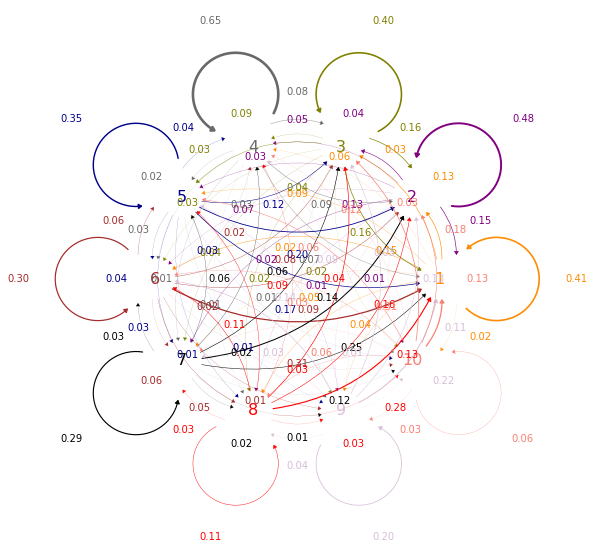

In [13]:
transition_graph(matrix_1030)

### 4050

In [14]:
gender = ['여성']
age = ['4050']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_F_4050 = transition_matrix(df_filtered)
color_df(matrix_F_4050)

100%|██████████| 687/687 [00:38<00:00, 17.82it/s]

total number of transitions:  45890


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.412267,0.150233,0.122089,0.029697,0.052504,0.088703,0.025427,0.055998,0.043672,0.019410
2,0.157541,0.496643,0.123972,0.040000,0.045201,0.027423,0.063924,0.024492,0.013050,0.007754
3,0.162123,0.160394,0.419737,0.036441,0.089507,0.026333,0.030722,0.036707,0.017556,0.020481
4,0.073920,0.093555,0.070455,0.652576,0.031185,0.018711,0.032571,0.013629,0.008778,0.004620
5,0.149920,0.204147,0.119617,0.040670,0.366295,0.025518,0.033759,0.034024,0.011164,0.014886
6,0.296093,0.104701,0.071429,0.019536,0.036630,0.332112,0.018620,0.053724,0.056471,0.010684
7,0.113333,0.276444,0.120000,0.062222,0.058222,0.035556,0.287111,0.022222,0.015556,0.009333
8,0.264100,0.127983,0.168655,0.031996,0.087852,0.122560,0.024946,0.103037,0.033080,0.035792
9,0.246097,0.096654,0.096654,0.034944,0.063941,0.168773,0.032714,0.052788,0.197770,0.009665


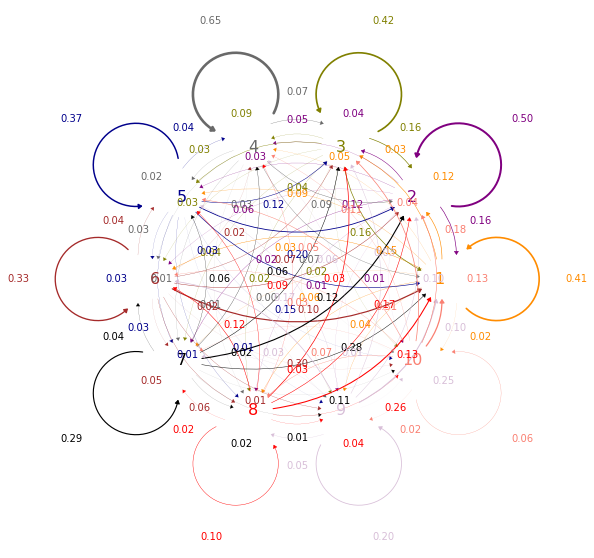

In [15]:
transition_graph(matrix_F_4050)

In [16]:
gender = ['남성']
age = ['4050']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_M_4050 = transition_matrix(df_filtered)
color_df(matrix_M_4050)

100%|██████████| 687/687 [01:13<00:00,  9.34it/s]


total number of transitions:  75585


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.445195,0.145010,0.112728,0.018653,0.044006,0.087434,0.022985,0.055844,0.045969,0.022176
2,0.146021,0.527518,0.118297,0.037063,0.042761,0.019618,0.068018,0.019677,0.013686,0.007342
3,0.158739,0.140980,0.459083,0.029651,0.080113,0.017446,0.029260,0.043107,0.018151,0.023471
4,0.054561,0.073321,0.064442,0.717743,0.019189,0.014464,0.032794,0.012172,0.007303,0.004010
5,0.138522,0.197096,0.114864,0.026921,0.417360,0.020069,0.035405,0.028716,0.009953,0.011095
6,0.321599,0.068616,0.058870,0.020088,0.034805,0.363564,0.020684,0.054893,0.047932,0.008950
7,0.113281,0.267969,0.122656,0.051302,0.052344,0.023698,0.321354,0.022917,0.016146,0.008333
8,0.294215,0.113364,0.169215,0.028258,0.081782,0.118684,0.024601,0.109707,0.028590,0.031582
9,0.237177,0.084174,0.112670,0.022359,0.057431,0.176238,0.017536,0.047786,0.228409,0.016221


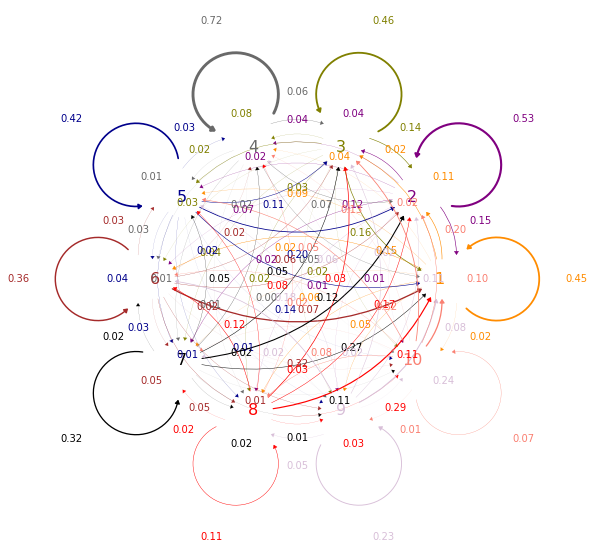

In [17]:
transition_graph(matrix_M_4050)

In [18]:
gender = None
age = ['4050']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_4050 = transition_matrix(df_filtered)
color_df(matrix_4050)

100%|██████████| 1374/1374 [02:10<00:00, 10.49it/s]

total number of transitions:  121475


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.432911,0.146959,0.116220,0.022773,0.047176,0.087907,0.023896,0.055902,0.045112,0.021144
2,0.150435,0.515688,0.120471,0.038188,0.043696,0.022609,0.066449,0.021522,0.013442,0.007500
3,0.159992,0.148170,0.444510,0.032166,0.083592,0.020738,0.029801,0.040737,0.017930,0.022363
4,0.061970,0.081064,0.066743,0.692804,0.023780,0.016089,0.032709,0.012730,0.007868,0.004243
5,0.142857,0.199778,0.116672,0.032150,0.397938,0.022141,0.034779,0.030735,0.010414,0.012537
6,0.311537,0.082852,0.063825,0.019870,0.035525,0.351156,0.019870,0.054432,0.051301,0.009634
7,0.113300,0.271100,0.121675,0.055337,0.054516,0.028079,0.308703,0.022660,0.015928,0.008703
8,0.282770,0.118920,0.169002,0.029678,0.084089,0.120157,0.024732,0.107172,0.030297,0.033182
9,0.240485,0.088803,0.106729,0.027027,0.059846,0.173469,0.023166,0.049641,0.217044,0.013789


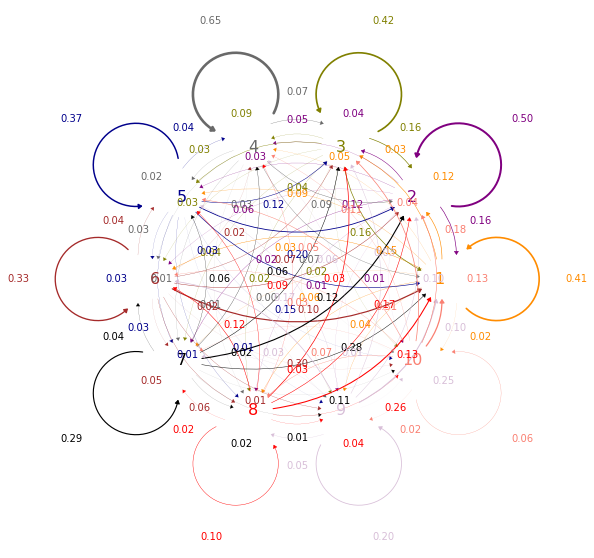

In [19]:
transition_graph(matrix_F_4050)

### 60+

In [20]:
gender = None
age = ['60+']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_60 = transition_matrix(df_filtered)
color_df(matrix_60)

100%|██████████| 1374/1374 [00:50<00:00, 27.06it/s]

total number of transitions:  59006


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.396649,0.163273,0.128560,0.038320,0.056127,0.079796,0.025471,0.052070,0.040574,0.019160
2,0.162020,0.475614,0.118208,0.052679,0.049899,0.033065,0.060194,0.024649,0.014804,0.008868
3,0.164190,0.154115,0.411870,0.046484,0.067631,0.031022,0.035212,0.045087,0.021147,0.023242
4,0.104906,0.102587,0.080999,0.571454,0.041035,0.026940,0.034790,0.017128,0.011775,0.008385
5,0.153438,0.179963,0.127525,0.043256,0.380127,0.026729,0.034891,0.030402,0.011630,0.012038
6,0.298294,0.117913,0.071751,0.036377,0.036126,0.320371,0.022579,0.049674,0.037381,0.009533
7,0.139770,0.248519,0.138027,0.056117,0.067619,0.032067,0.264552,0.026142,0.018822,0.008365
8,0.255892,0.135943,0.182239,0.034512,0.082912,0.101431,0.039562,0.103956,0.027778,0.035774
9,0.218458,0.126168,0.130841,0.035047,0.061916,0.124416,0.030374,0.043808,0.216706,0.012266


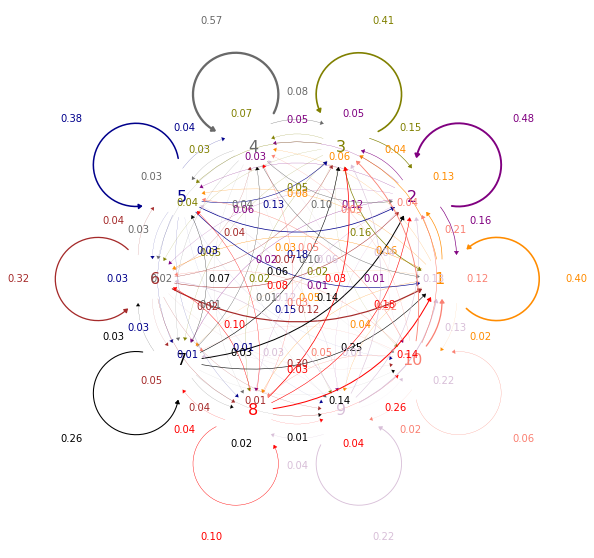

In [25]:
transition_graph(matrix_60)

In [21]:
gender = ['남성']
age = ['60+']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_M_60 = transition_matrix(df_filtered)
color_df(matrix_M_60)

100%|██████████| 687/687 [00:28<00:00, 23.77it/s]

total number of transitions:  35398


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.407819,0.158756,0.129653,0.032476,0.049588,0.084062,0.025606,0.051461,0.043093,0.017487
2,0.157830,0.494129,0.116796,0.050179,0.046101,0.031640,0.058954,0.022741,0.013843,0.007786
3,0.164942,0.151963,0.422211,0.044193,0.068342,0.028586,0.034171,0.041400,0.021850,0.022343
4,0.093843,0.098924,0.078900,0.603706,0.037059,0.022415,0.032875,0.016736,0.008069,0.007472
5,0.146515,0.183855,0.126956,0.043030,0.389758,0.025249,0.033073,0.029872,0.008890,0.012802
6,0.307061,0.105090,0.072250,0.028736,0.029146,0.341133,0.020115,0.049261,0.036535,0.010673
7,0.127509,0.239669,0.141086,0.055490,0.069067,0.030106,0.284534,0.027155,0.016529,0.008855
8,0.274439,0.136133,0.179580,0.035482,0.080377,0.098479,0.033309,0.104272,0.025344,0.032585
9,0.211672,0.124629,0.128586,0.030663,0.068249,0.138477,0.022750,0.049456,0.211672,0.013848


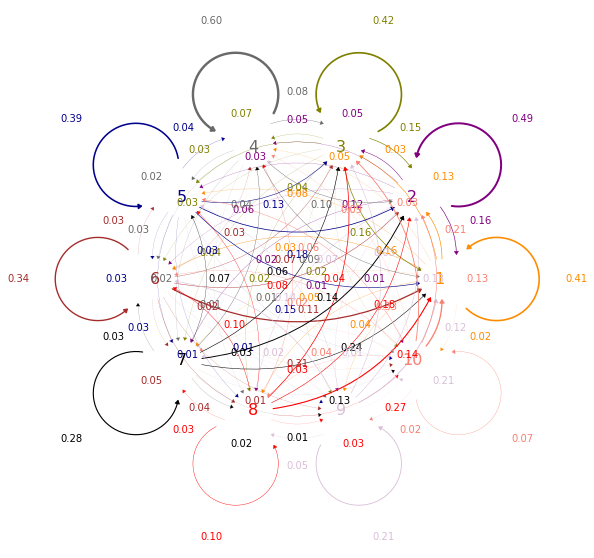

In [24]:
transition_graph(matrix_M_60)

In [22]:
gender = ['여성']
age = ['60+']
region = None
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)

matrix_F_60 = transition_matrix(df_filtered)
color_df(matrix_F_60)

100%|██████████| 687/687 [00:18<00:00, 36.24it/s]

total number of transitions:  23608


next_state,1,2,3,4,5,6,7,8,9,10
state,,,,,,,,,,
1,0.379785,0.170092,0.126909,0.047143,0.066000,0.073355,0.025269,0.052989,0.036772,0.021686
2,0.168520,0.446894,0.120399,0.056557,0.055790,0.035276,0.062117,0.027607,0.016296,0.010544
3,0.163027,0.157440,0.395886,0.050025,0.066531,0.034789,0.036821,0.050787,0.020061,0.024632
4,0.121293,0.108012,0.084108,0.523683,0.046923,0.033643,0.037627,0.017707,0.017264,0.009739
5,0.162757,0.174725,0.128291,0.043562,0.367161,0.028722,0.037338,0.031115,0.015318,0.011010
6,0.284516,0.138065,0.070968,0.048387,0.047097,0.287742,0.026452,0.050323,0.038710,0.007742
7,0.157447,0.261277,0.133617,0.057021,0.065532,0.034894,0.235745,0.024681,0.022128,0.007660
8,0.230151,0.135678,0.185930,0.033166,0.086432,0.105528,0.048241,0.103518,0.031156,0.040201
9,0.228245,0.128388,0.134094,0.041369,0.052782,0.104137,0.041369,0.035663,0.223966,0.009986


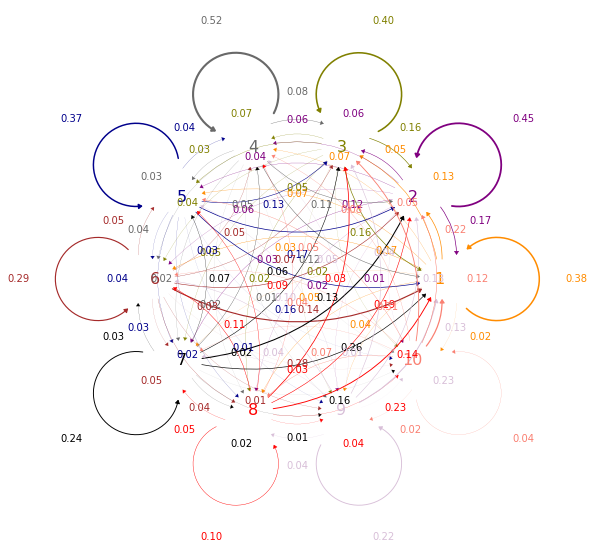

In [23]:
transition_graph(matrix_F_60)

### 수도권

### 비수도권

# 2.. 월별 변화 

## 고객 전체

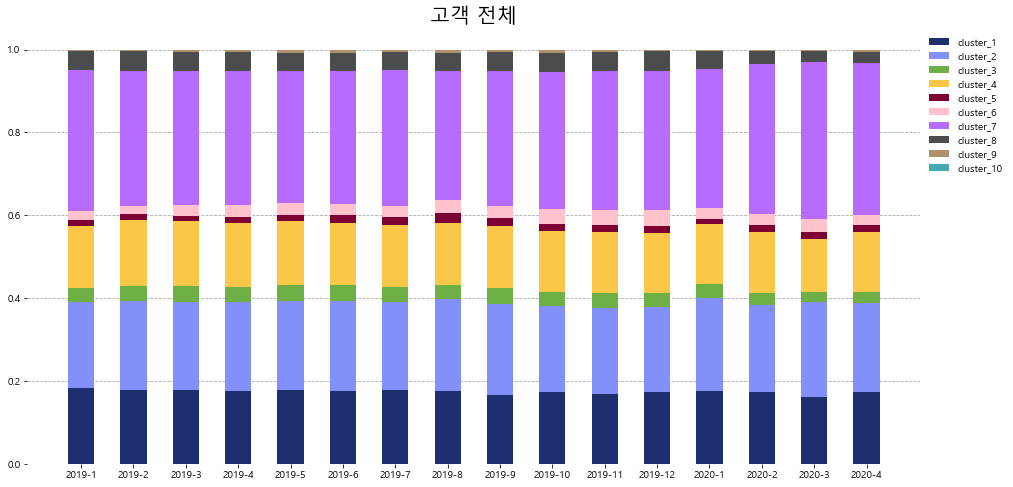

In [62]:
df = preprocess_money(merged_grouped, 10)
plot_stackedbar_v(df, colors, title='고객 전체')

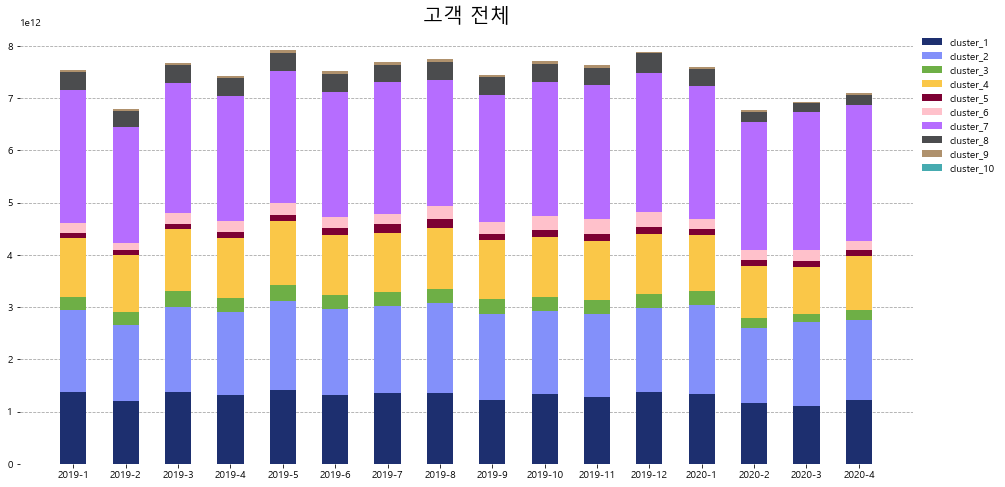

In [63]:
df = preprocess_money_abs(merged_grouped)
plot_stackedbar_v(df, colors, title='고객 전체')

## 고객 그룹별
- merged 에서 preprocess 함수 통해 data[['년','월','cluster', '이용금액']] 만 가져 옴
- 우선 이렇게 그려 보기
    - 성별, 2030 4050 60
    - 수도권, 소득1 소득2 소득3
- '비슷한 클러스터끼리 비슷한 색칠하기: 파란색 계열, 빨간색 계열 그라데이션'

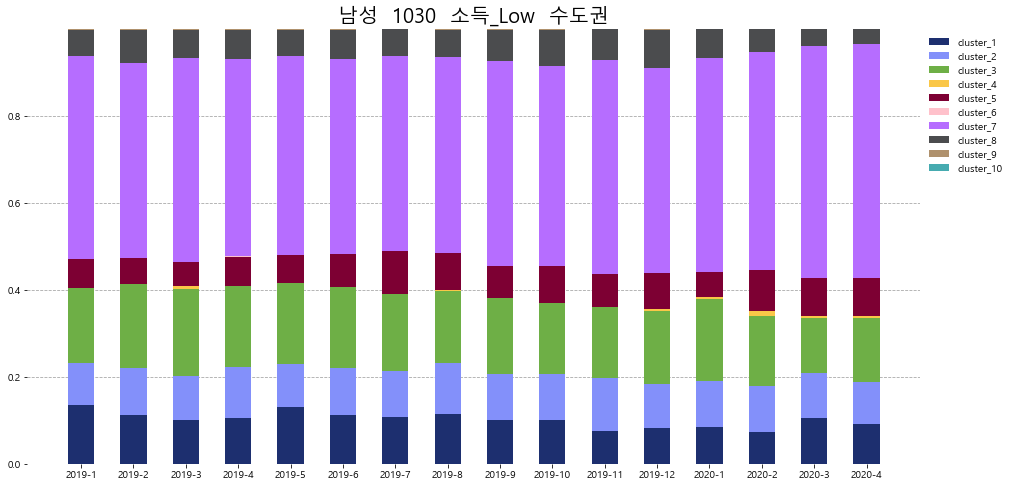

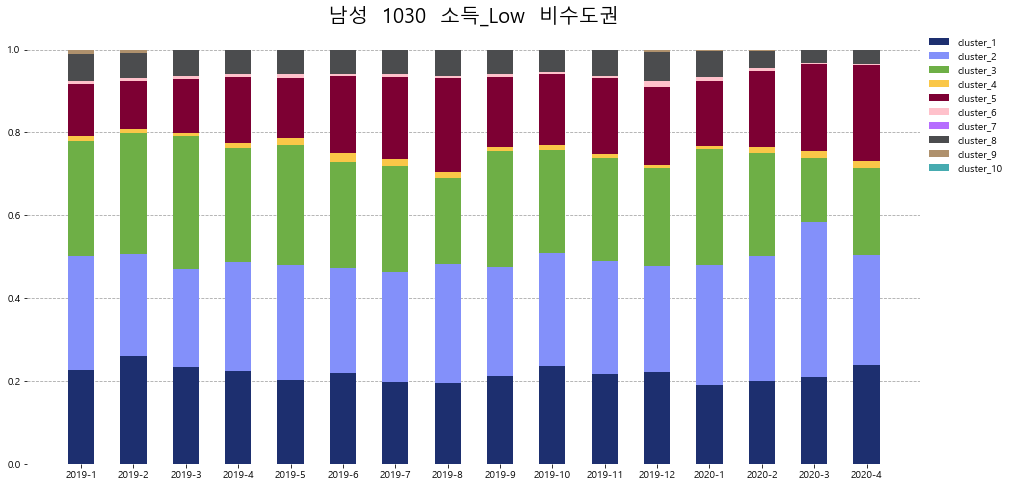

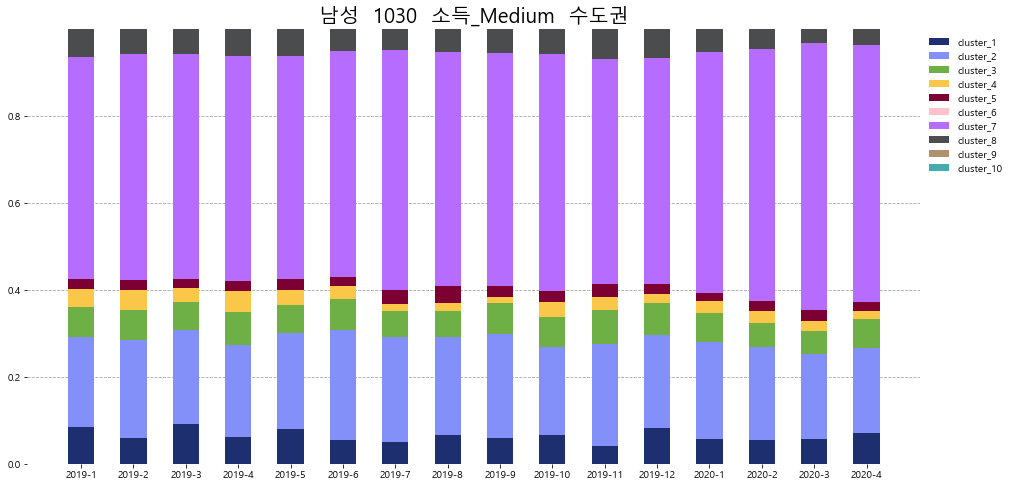

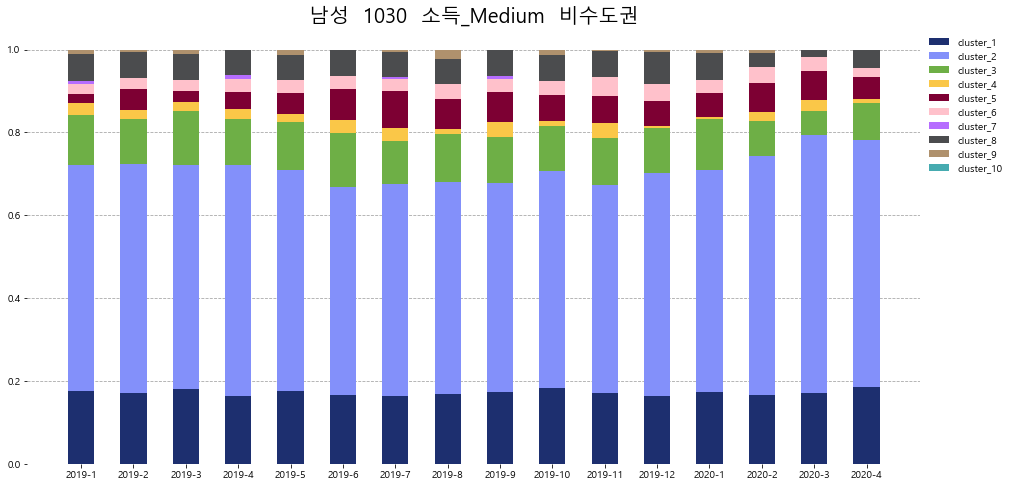

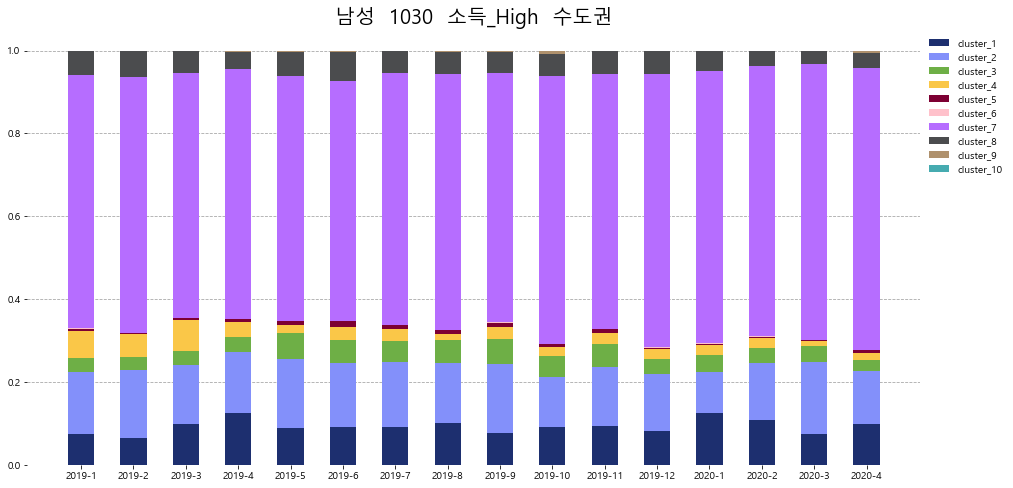

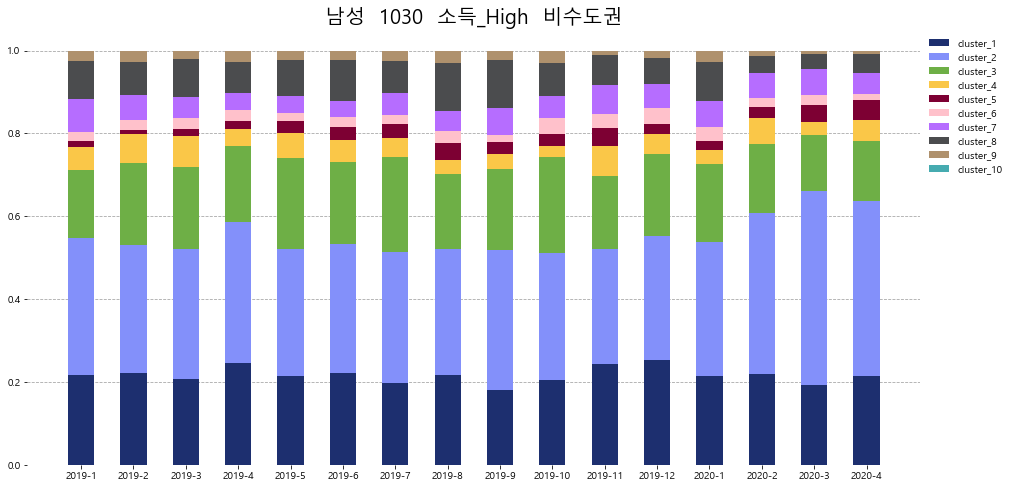

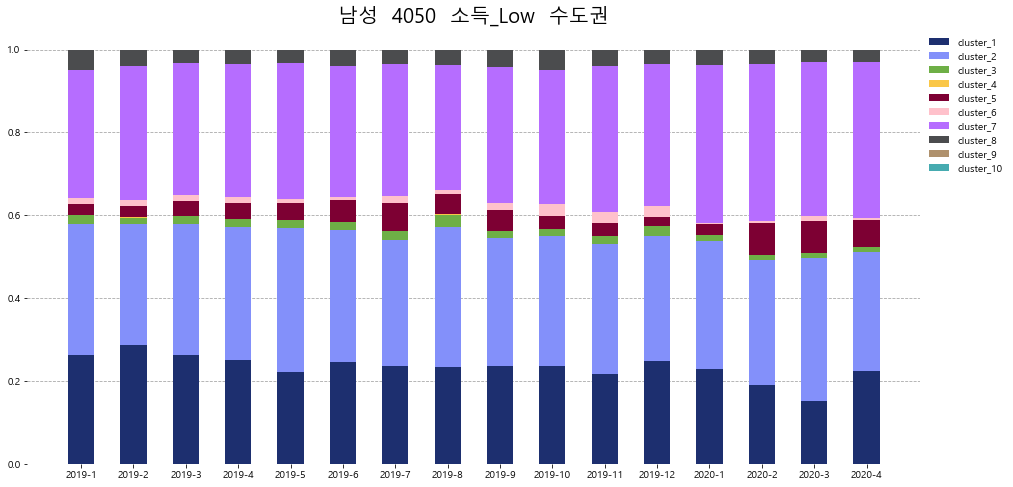

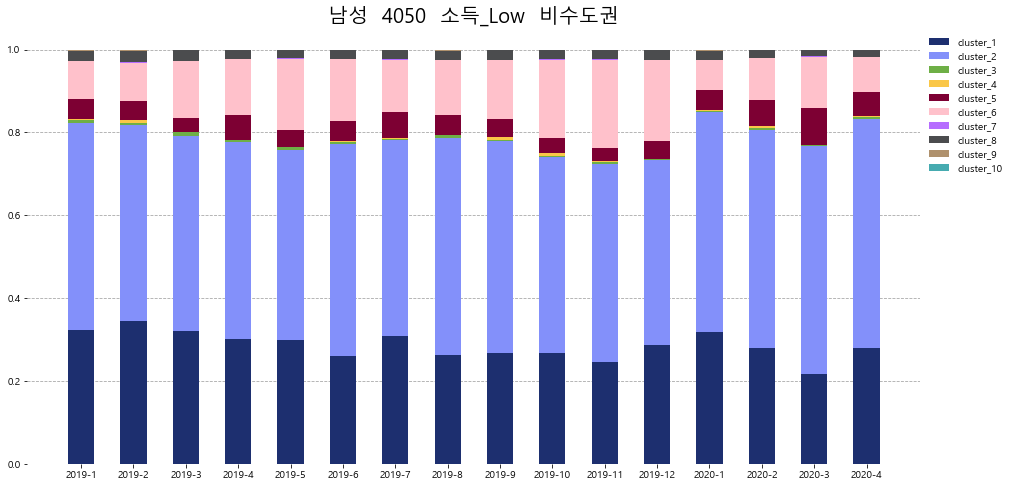

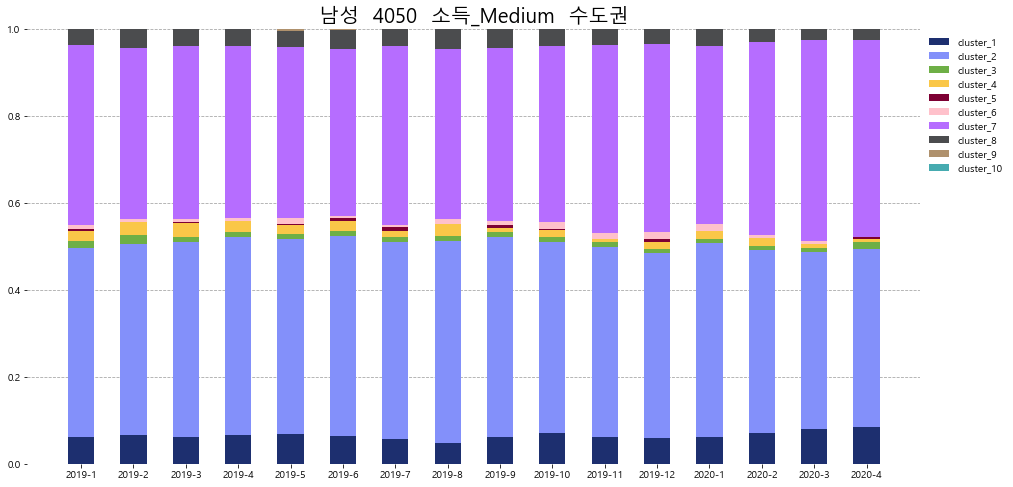

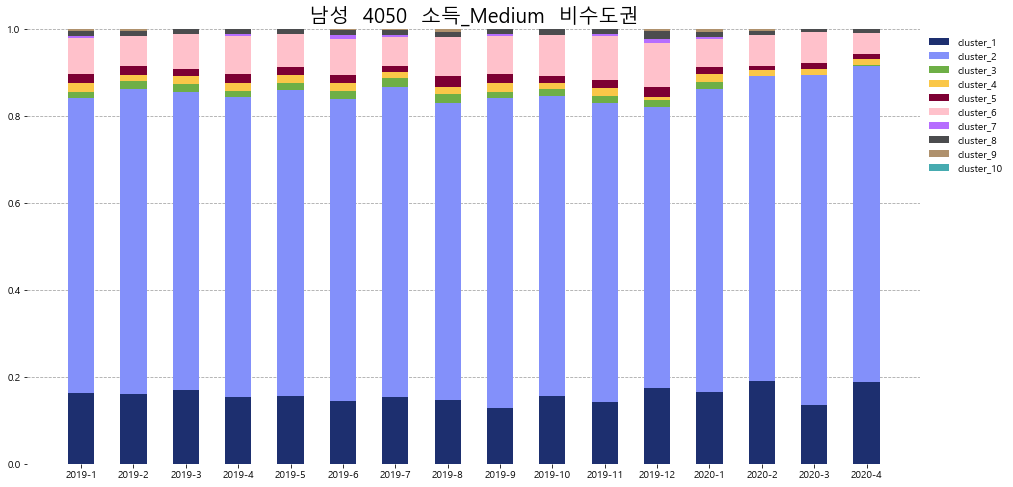

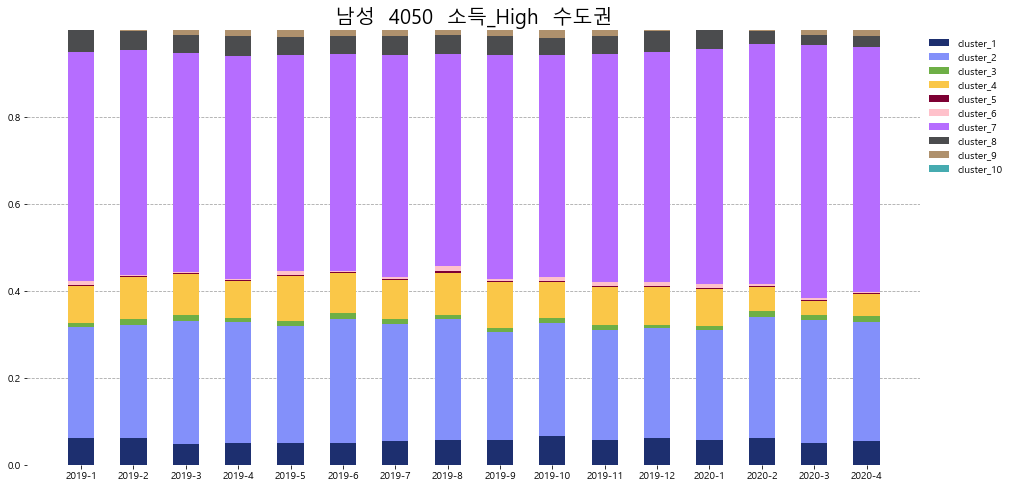

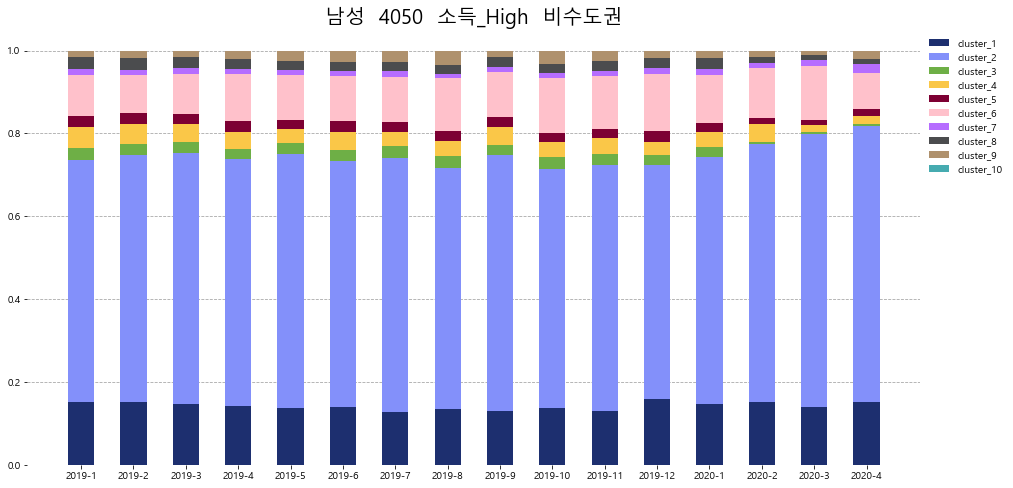

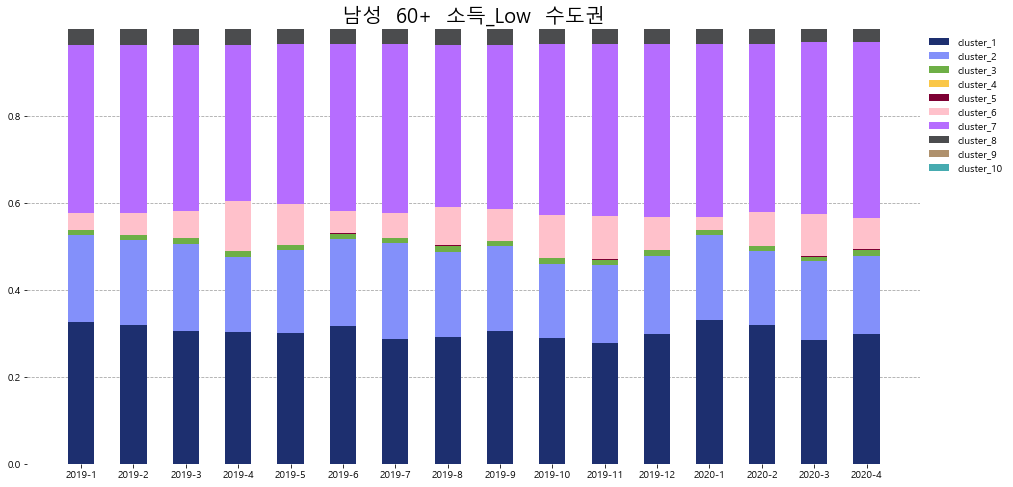

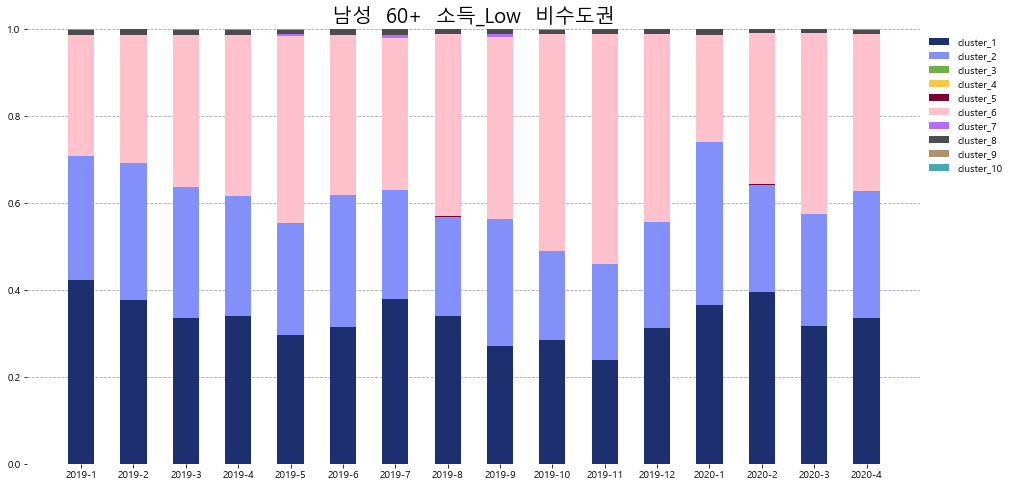

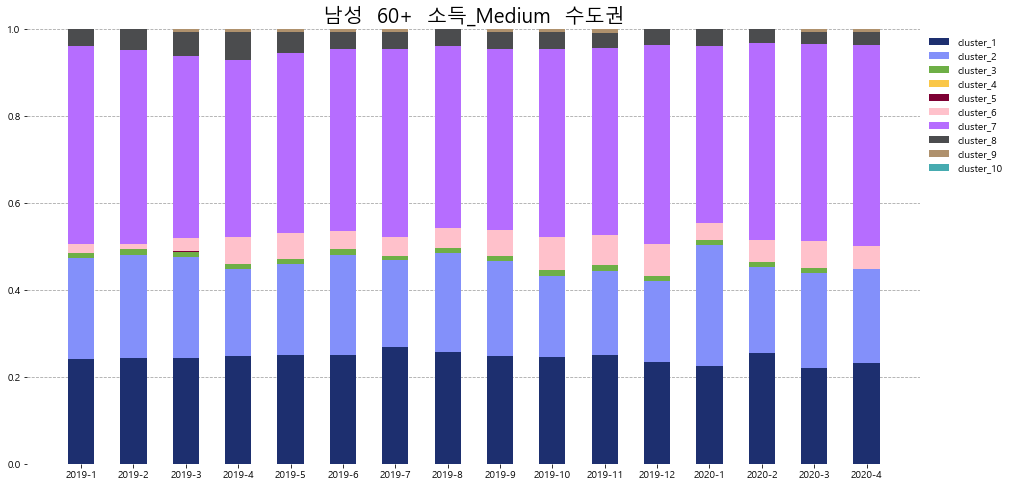

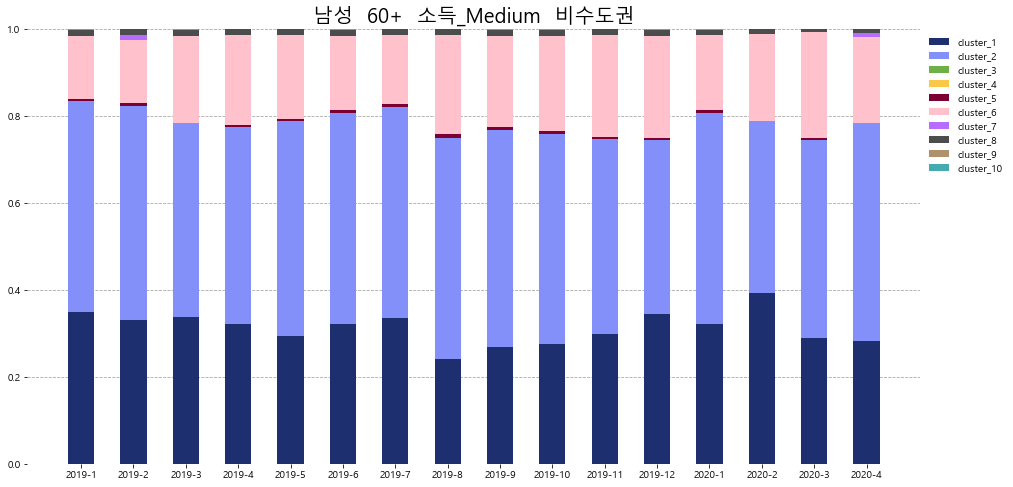

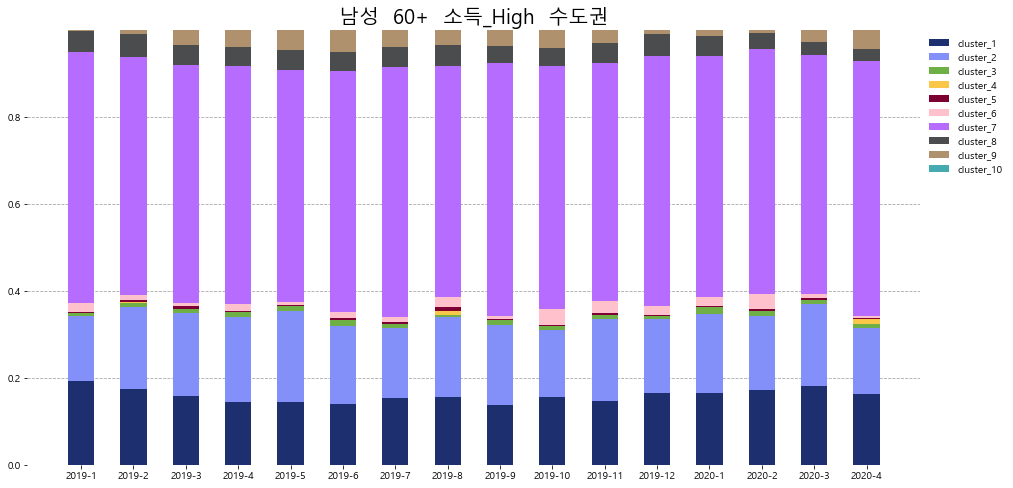

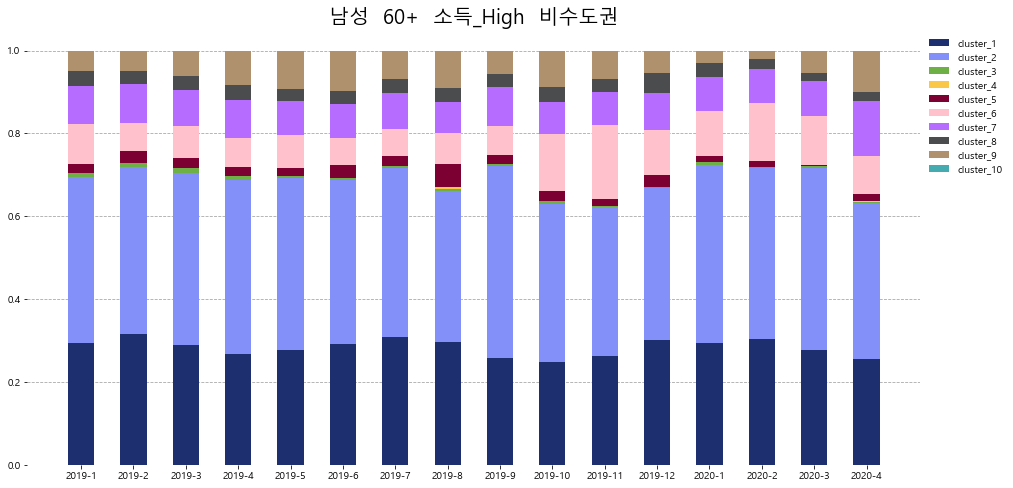

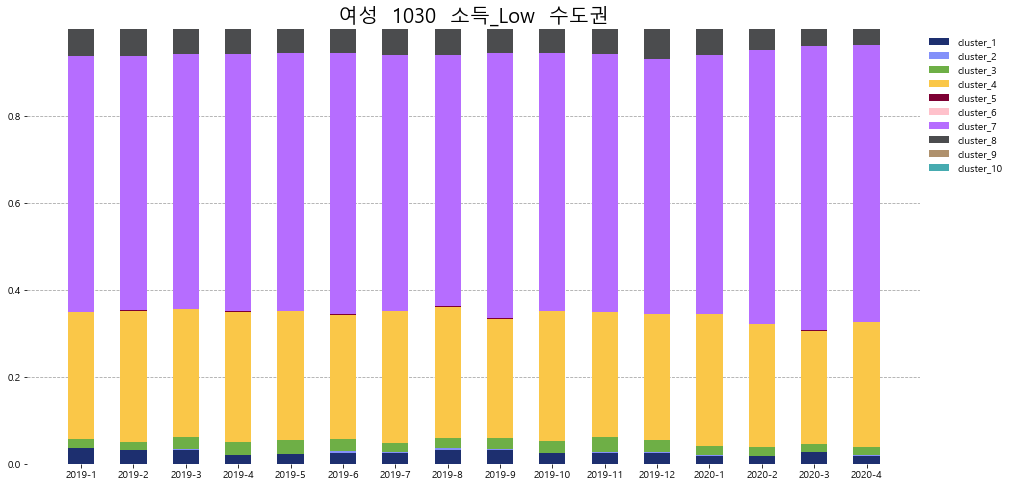

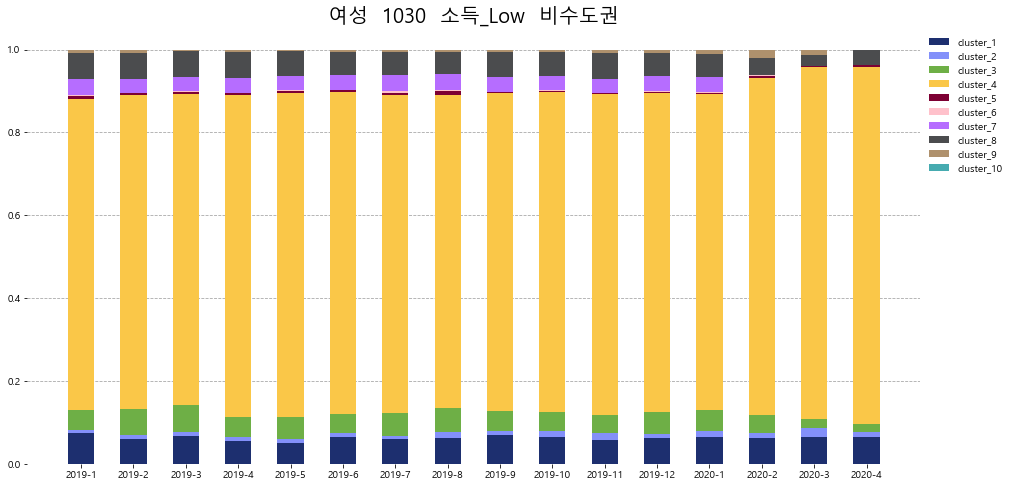

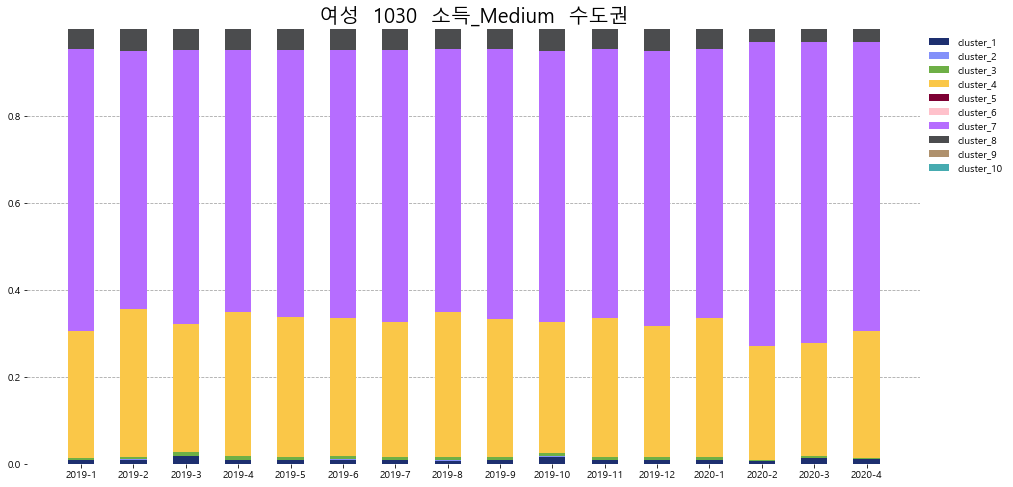

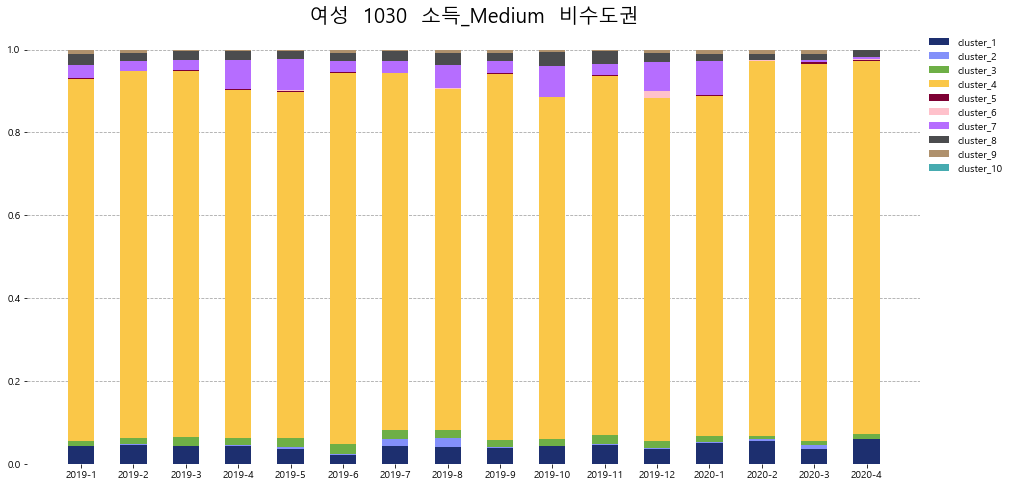

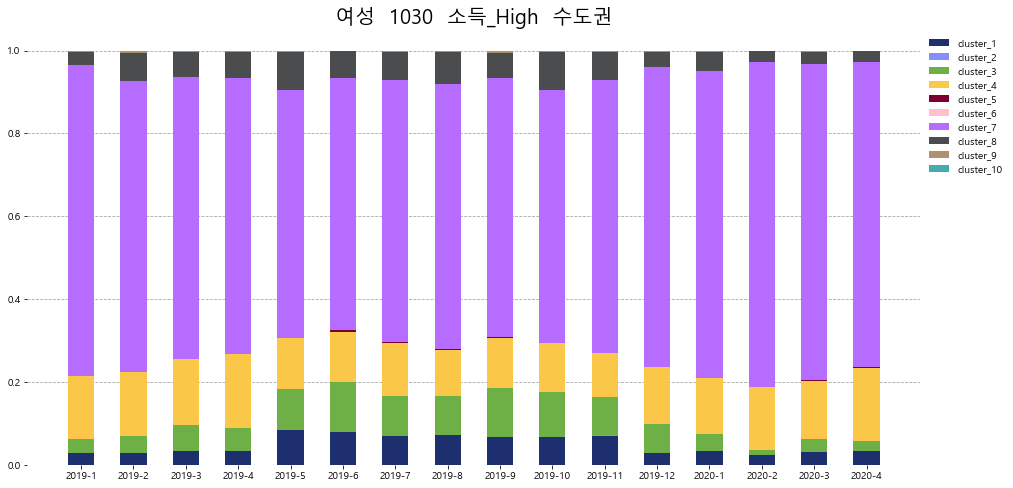

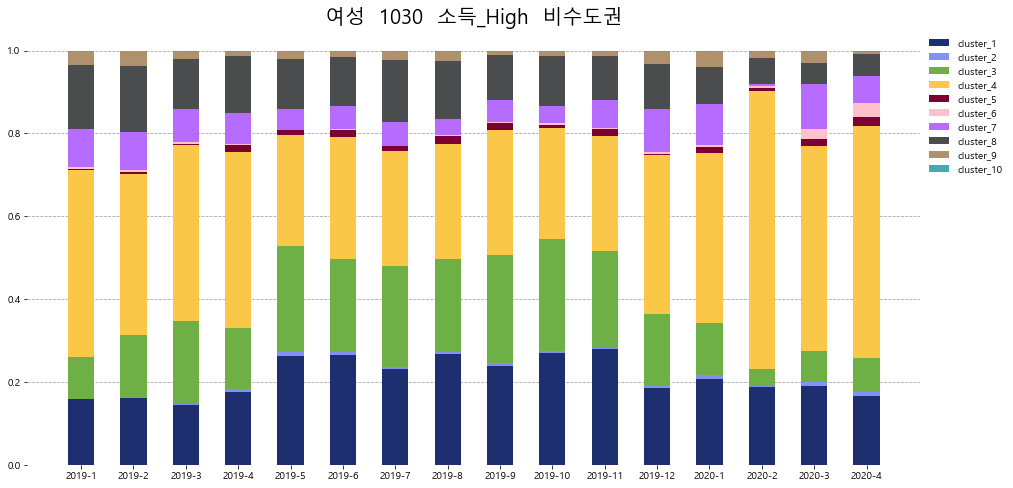

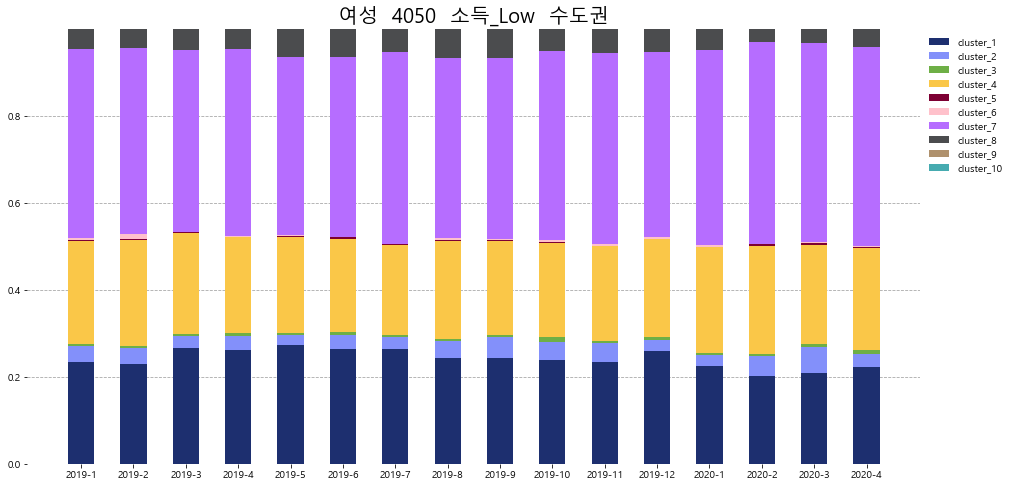

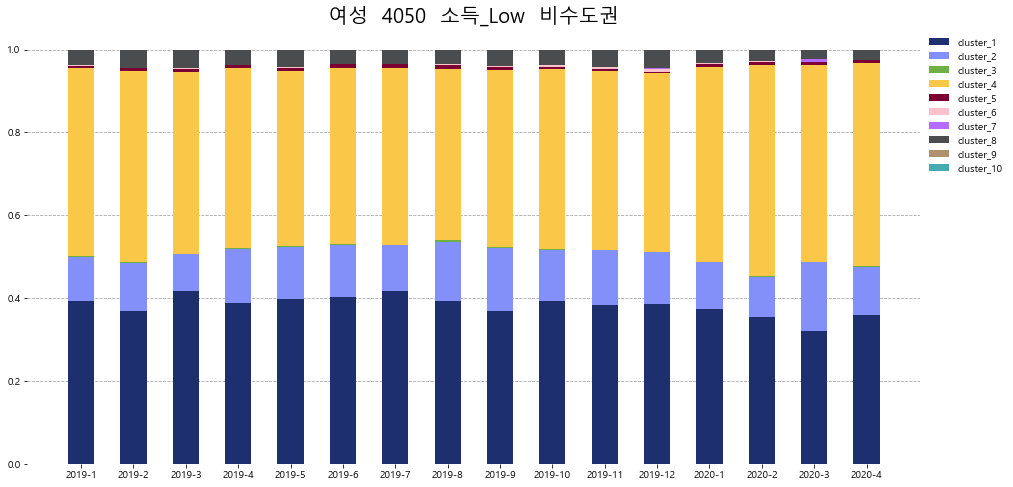

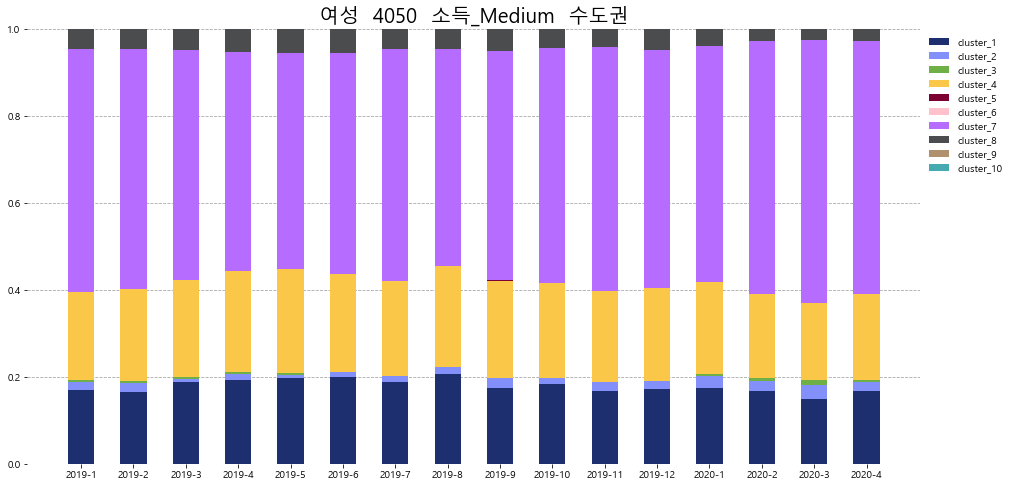

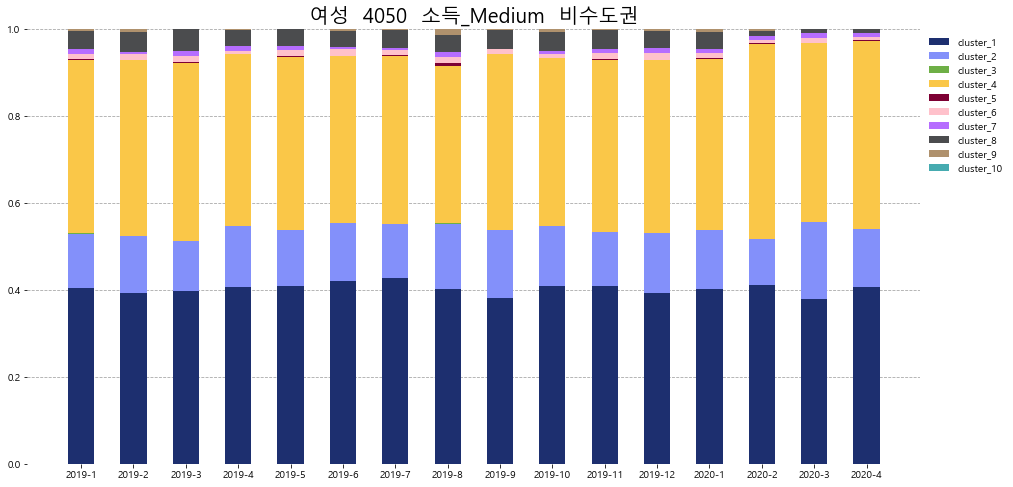

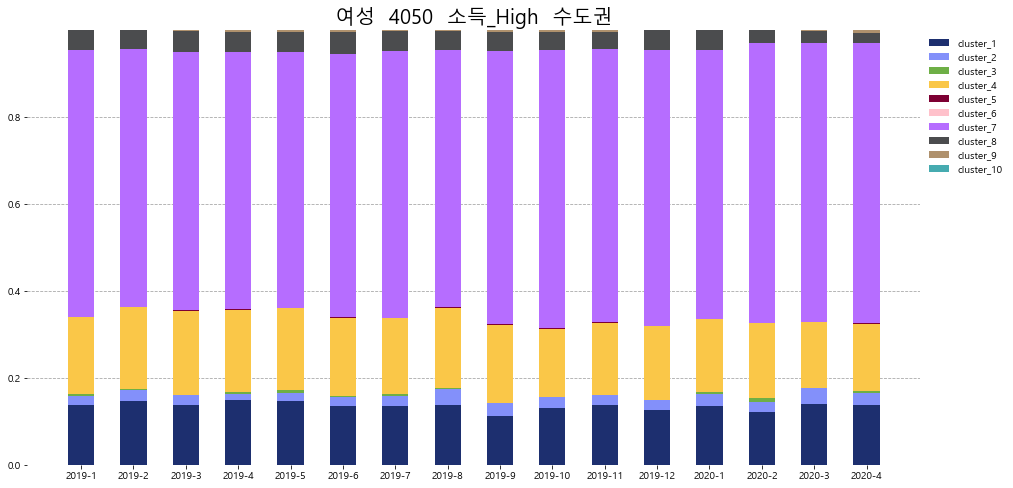

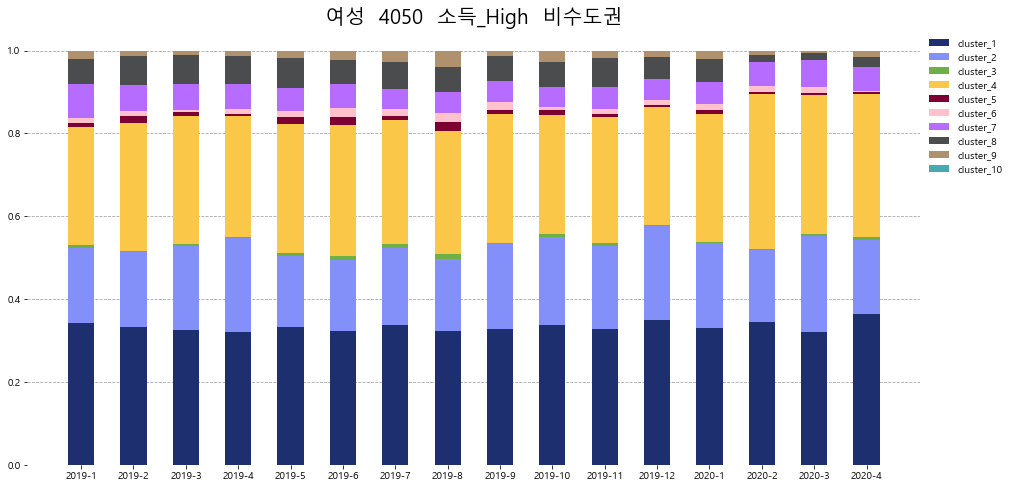

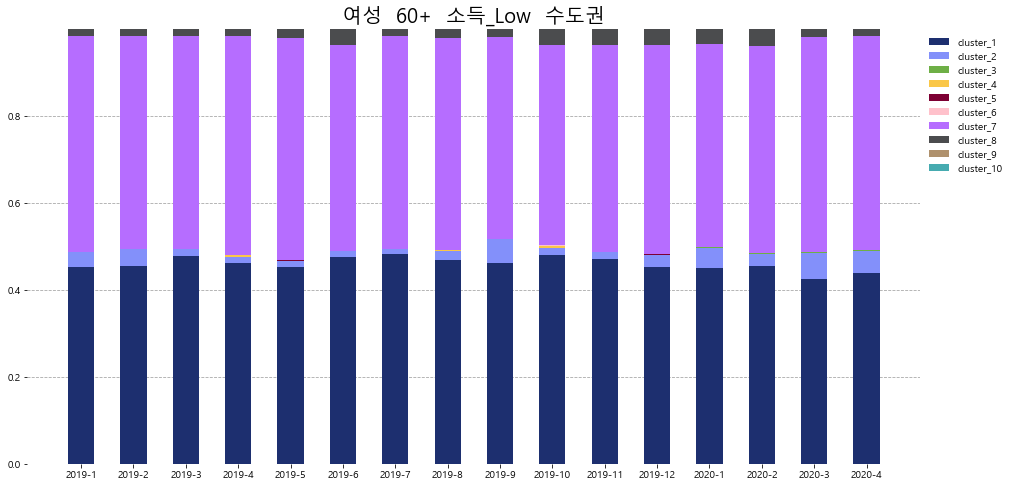

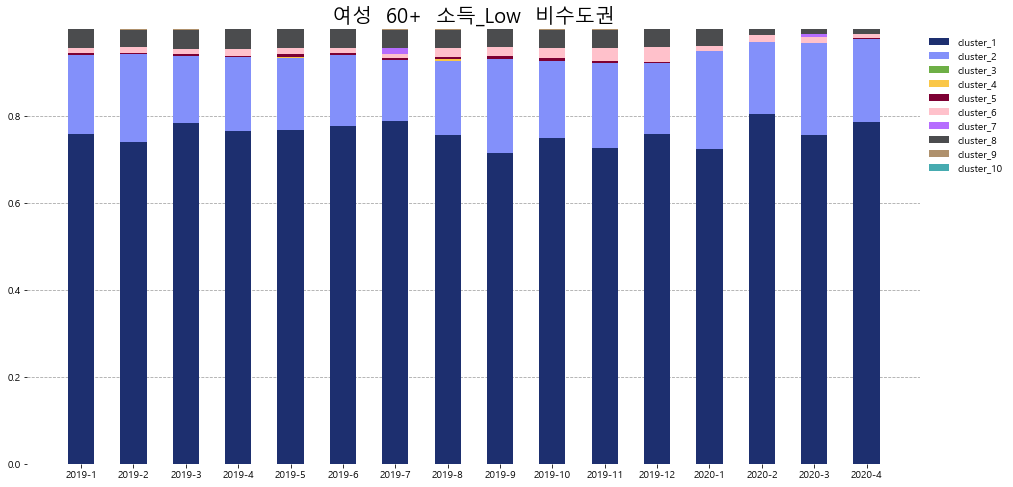

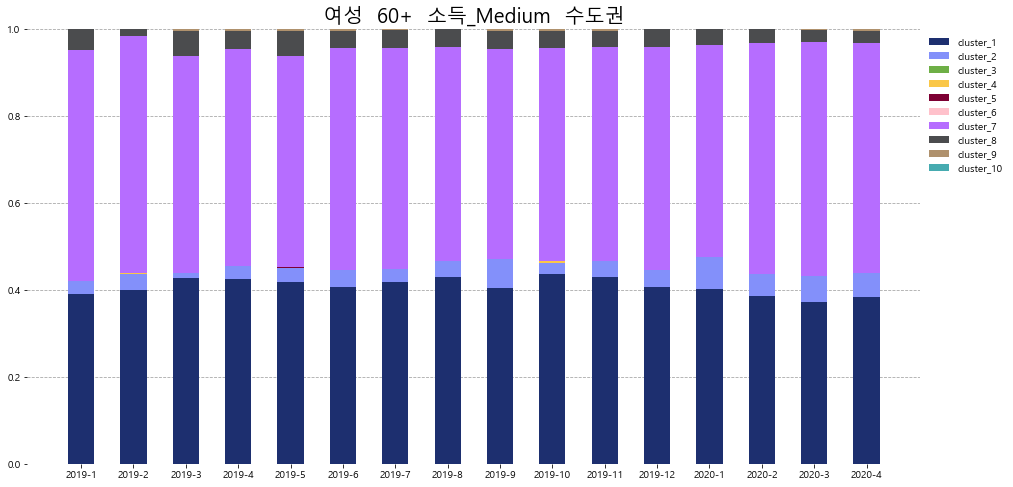

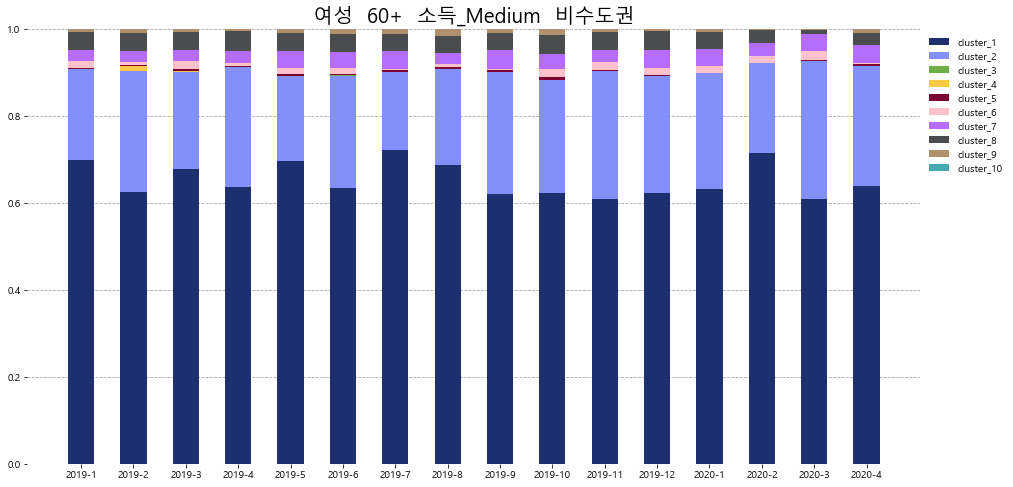

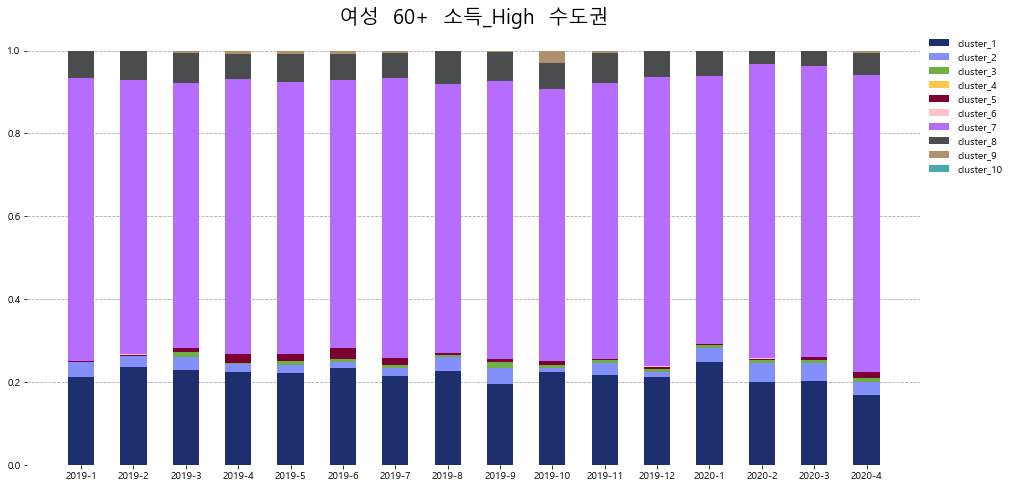

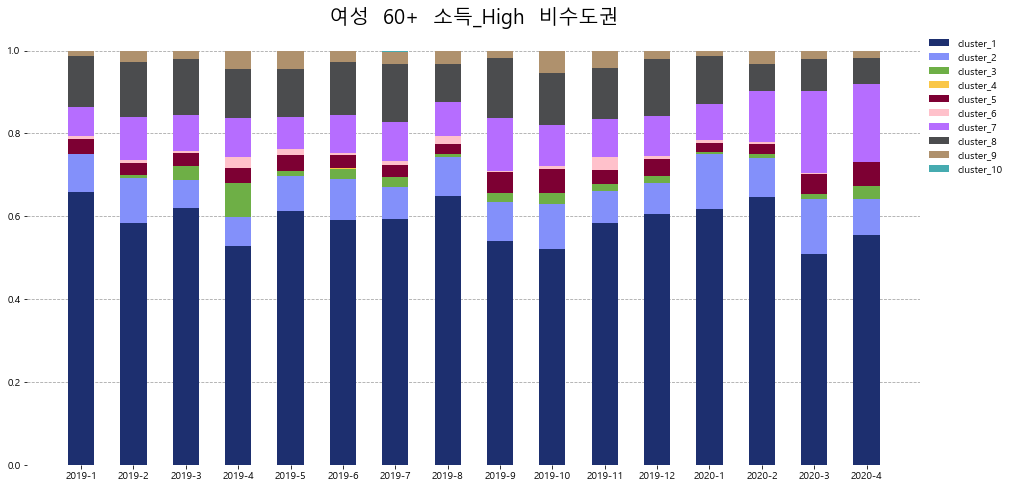

In [8]:
# 성별 연령대별 연평균소득추정 지역

gender_list = merged_grouped['성별'].unique().tolist()
age_list = merged_grouped['연령대별'].unique().tolist()
income_list = merged_grouped['연평균소득추정'].unique().tolist()
region_list = merged_grouped['지역'].unique().tolist()

k=10

for gender in gender_list:
    for age in age_list:
        for income in income_list:
            for region in region_list:
                df_filtered = filter_df(merged_grouped, [gender], [age], [income], [region])
                df = preprocess_money(df_filtered, k)
                plot_stackedbar_v(df, colors, title='{0}  {1}  {2}  {3}'.format(gender, age, income, region))


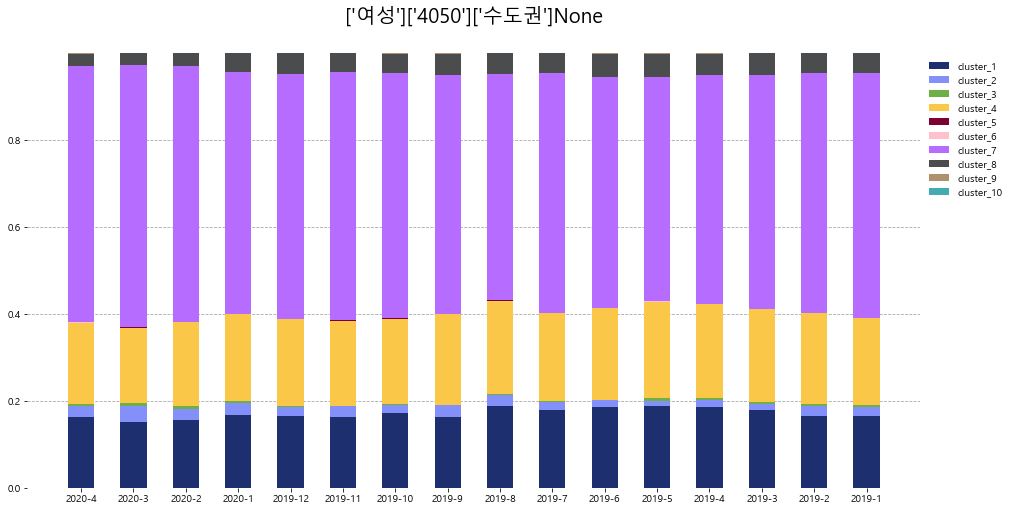

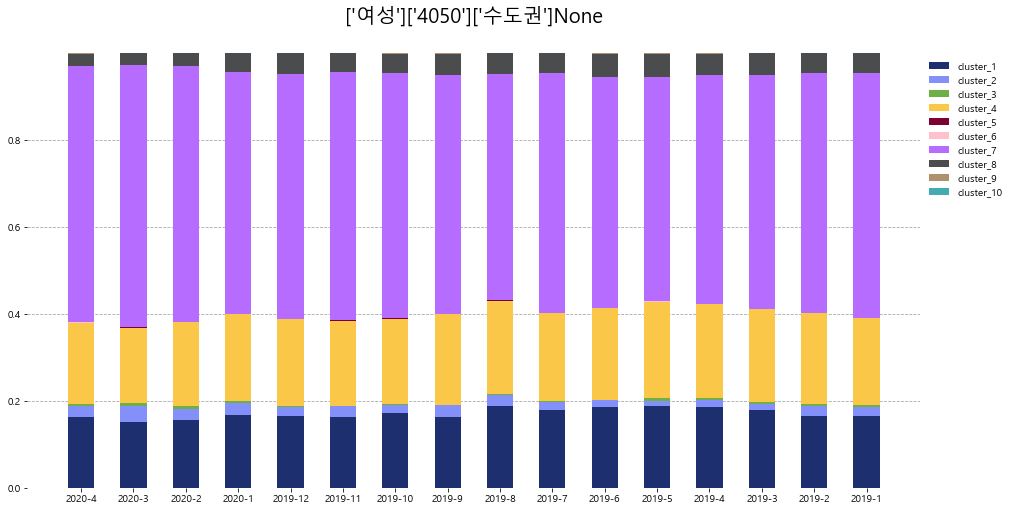

In [13]:
gender = ['여성']
age = ['4050']
region = ['수도권']
income = None

df_filtered = filter_df(merged_grouped, gender, age, income, region)
df = preprocess_money(df_filtered)
plot_stackedbar_v(df, colors, title='{}{}{}{}\n'.format(gender, age, region, income))

# 3.. 클러스터 & 고객 비중

In [9]:
merged_grouped.head()

,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,지역,가정용품,개인미용,...,여객운송,오락_문화,음식점,의류_잡화,전자상거래,정보통신,종합소매,주거,cluster,이용금액
0,2019,1,경기도,가평군,남성,1030,소득_Low,수도권,0.0,0.000000,...,0.0,0.043812,0.327448,0.058830,0.0,0.000000,0.495890,0.000000,5,8390330.0
1,2019,1,경기도,가평군,남성,1030,소득_Low,수도권,0.0,0.013577,...,0.0,0.060357,0.395716,0.042880,0.0,0.000417,0.324901,0.010090,5,143975888.0
2,2019,1,경기도,가평군,남성,1030,소득_Low,수도권,0.0,0.006469,...,0.0,0.055328,0.393759,0.023631,0.0,0.000163,0.320731,0.011607,5,245555936.0
3,2019,1,경기도,가평군,남성,1030,소득_Medium,수도권,0.0,0.005835,...,0.0,0.054971,0.416707,0.022155,0.0,0.000000,0.354613,0.015210,5,119837440.0
4,2019,1,경기도,가평군,남성,1030,소득_High,수도권,0.0,0.000000,...,0.0,0.086319,0.330401,0.012763,0.0,0.000000,0.438105,0.013784,5,8630734.0


cluster:  1


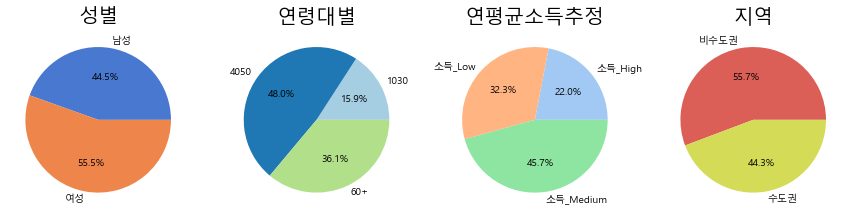

cluster:  2


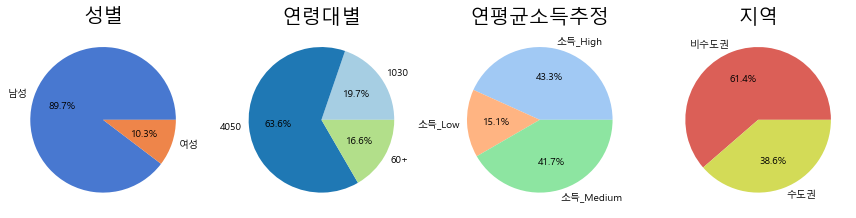

cluster:  3


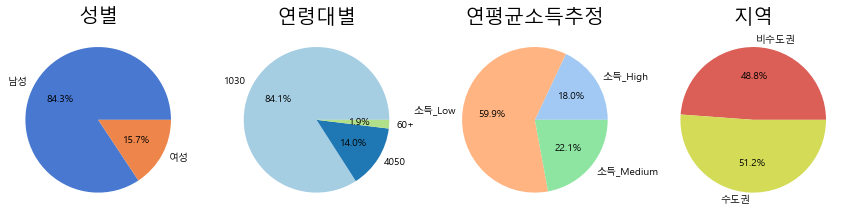

cluster:  4


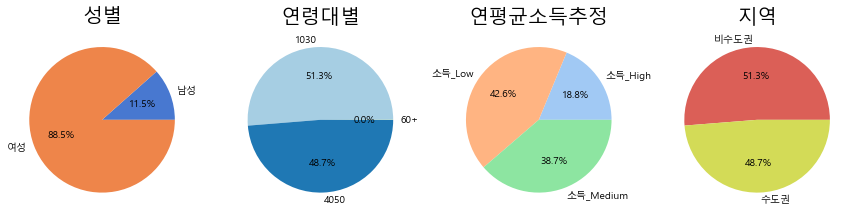

cluster:  5


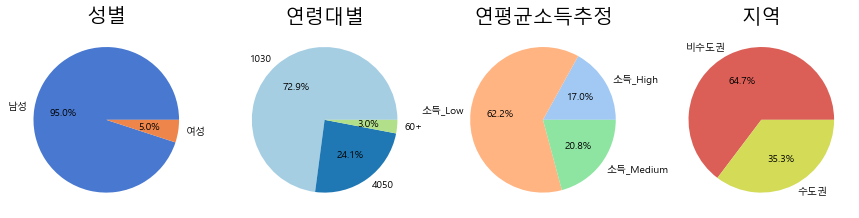

cluster:  6


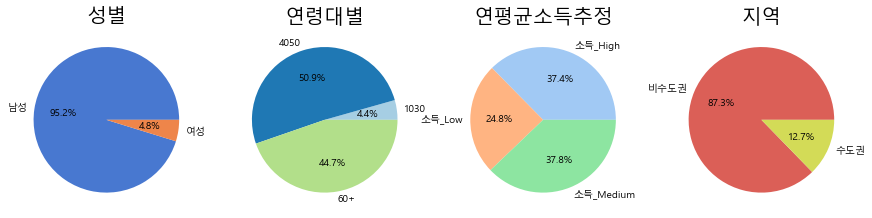

cluster:  7


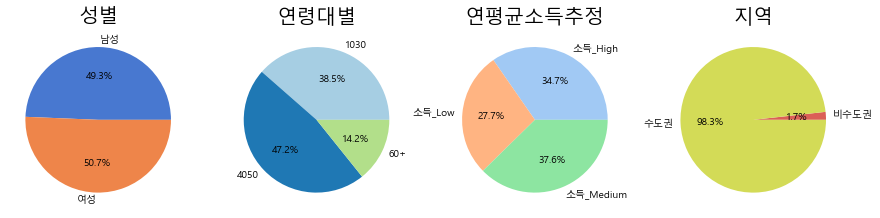

cluster:  8


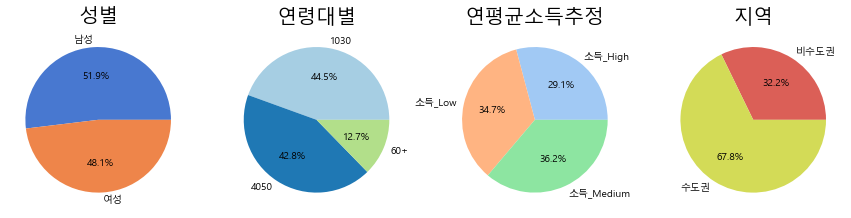

cluster:  9


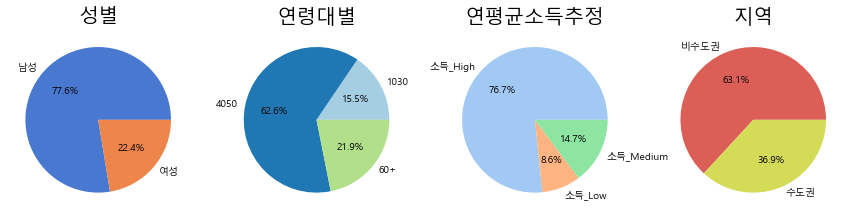

cluster:  10


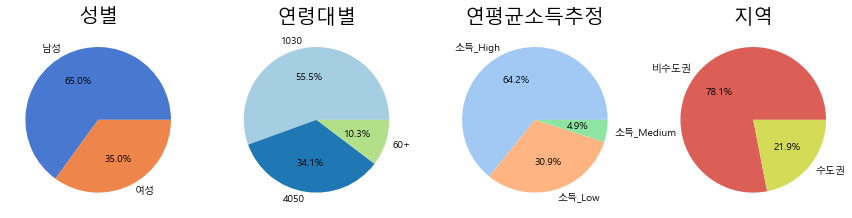

In [39]:
palette_list = []
name_list = ['muted', 'Paired', 'pastel', 'hls']
for name in name_list:
    palette_list.append(sns.color_palette(name))


clusters = sorted(merged_grouped['cluster'].unique())
features = ['성별', '연령대별', '연평균소득추정', '지역']

for c in clusters:
    print('cluster: ', c)
    df = merged_grouped[merged_grouped['cluster'] == c]
    # pie plot
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes.flatten()):
        feature = df[features].columns[i]

        counts = df.groupby(feature).sum('이용금액')['이용금액'].sort_index() # 금액 말고 카운트 기준: counts = df[feature].value_counts().sort_index()
        labels = counts.index

        colours = dict(zip(labels, palette_list[i][:len(labels)]))
        ax.pie(counts, labels=labels,
               autopct="%.1f%%", textprops={'fontsize': 10}, colors=[colours[v] for v in counts.keys()])
        ax.set_title("{}".format(feature), fontsize=20)
    plt.show()
